In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.models import load_model

#for data processing
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

import pickle

import time

import matplotlib.pyplot as plt

import matplotlib.colors as clrs

from mpl_toolkits.axes_grid1 import make_axes_locatable

Using TensorFlow backend.


In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#get raw data
TRAIN_PATH_IN = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/train/in/'
VAL_PATH_IN = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/val/in/'
TEST_PATH_IN = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/test/in/'

TRAIN_PATH_REF = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/train/ref/'
VAL_PATH_REF = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/val/ref/'
TEST_PATH_REF = '/media/oala/4TB/DATA/experiments-hhi/uncertainty-quant/ellipsoid-toy/denoising/test/ref/'


def get_data(path):
    TRAIN_PATH = path
    train_names = next(os.walk(TRAIN_PATH))[2]
    X_train = np.zeros((len(train_names), 512, 512), dtype=np.float64)
    print('Getting and resizing train images and masks ... ')
    for image_name, count in zip(train_names, range(len(train_names))):
        img = imread(TRAIN_PATH + image_name)
        #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[count] = img
        if count % 500 == 0:
            print('Done with # ', count)
    X_train = X_train[:,:,:,np.newaxis]
    
    return X_train

X_train = get_data(TRAIN_PATH_IN)
Y_train = get_data(TRAIN_PATH_REF)

X_val = get_data(VAL_PATH_IN)
Y_val = get_data(VAL_PATH_REF)

Getting and resizing train images and masks ... 
Done with #  0
Done with #  500
Done with #  1000
Done with #  1500
Getting and resizing train images and masks ... 
Done with #  0
Done with #  500
Done with #  1000
Done with #  1500
Getting and resizing train images and masks ... 
Done with #  0
Getting and resizing train images and masks ... 
Done with #  0


In [3]:
#get outputted data
train_matrices_path = "/home/oala/Documents/experiments-hhi/uncertainty-quant/preliminary-experiments/denoising/prob/run-7_linearprevar-linearmean-propperdatapreprocessing/matrices-train/epoch15.pickle"
test_matrices_path = "/home/oala/Documents/experiments-hhi/uncertainty-quant/preliminary-experiments/denoising/prob/run-7_linearprevar-linearmean-propperdatapreprocessing/matrices-test/epoch15.pickle"

with open(train_matrices_path, 'rb') as handle:
        matrices = pickle.load(handle)
        imgs_train = matrices['imgs']
        refs_train = matrices['refs']
        mean_out_train = matrices['mean_out']
        var_out_train = matrices['var_out']
        
with open(test_matrices_path, 'rb') as handle:
        matrices = pickle.load(handle)
        imgs_test = matrices['imgs']
        refs_test = matrices['refs']
        mean_out_test = matrices['mean_out']
        var_out_test = matrices['var_out']

In [5]:
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train - X_train_mean, axis=0)

In [12]:
X_normal = X_train[0]
X_demeaned = X_train[0] - X_train_mean
X_demeaned_normalized = (X_train[0] - X_train_mean)/X_train_std
X_rec = X_demeaned_normalized*X_train_std + X_train_mean
X_rec_diff = np.abs(X_rec-X_normal)

In [13]:
a = [X_normal, X_rec, X_rec_diff, X_demeaned, X_demeaned_normalized]

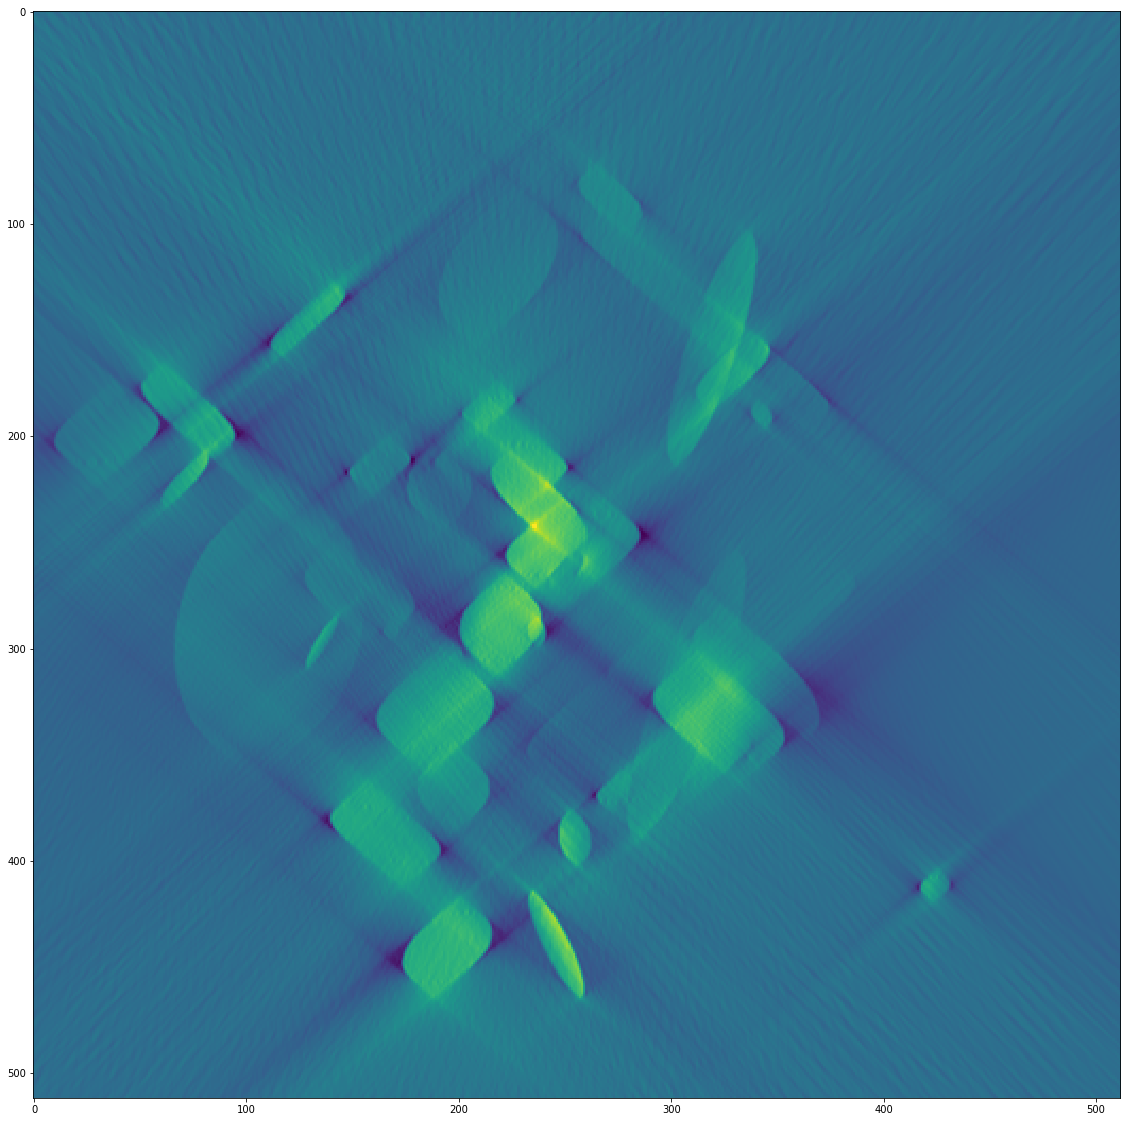

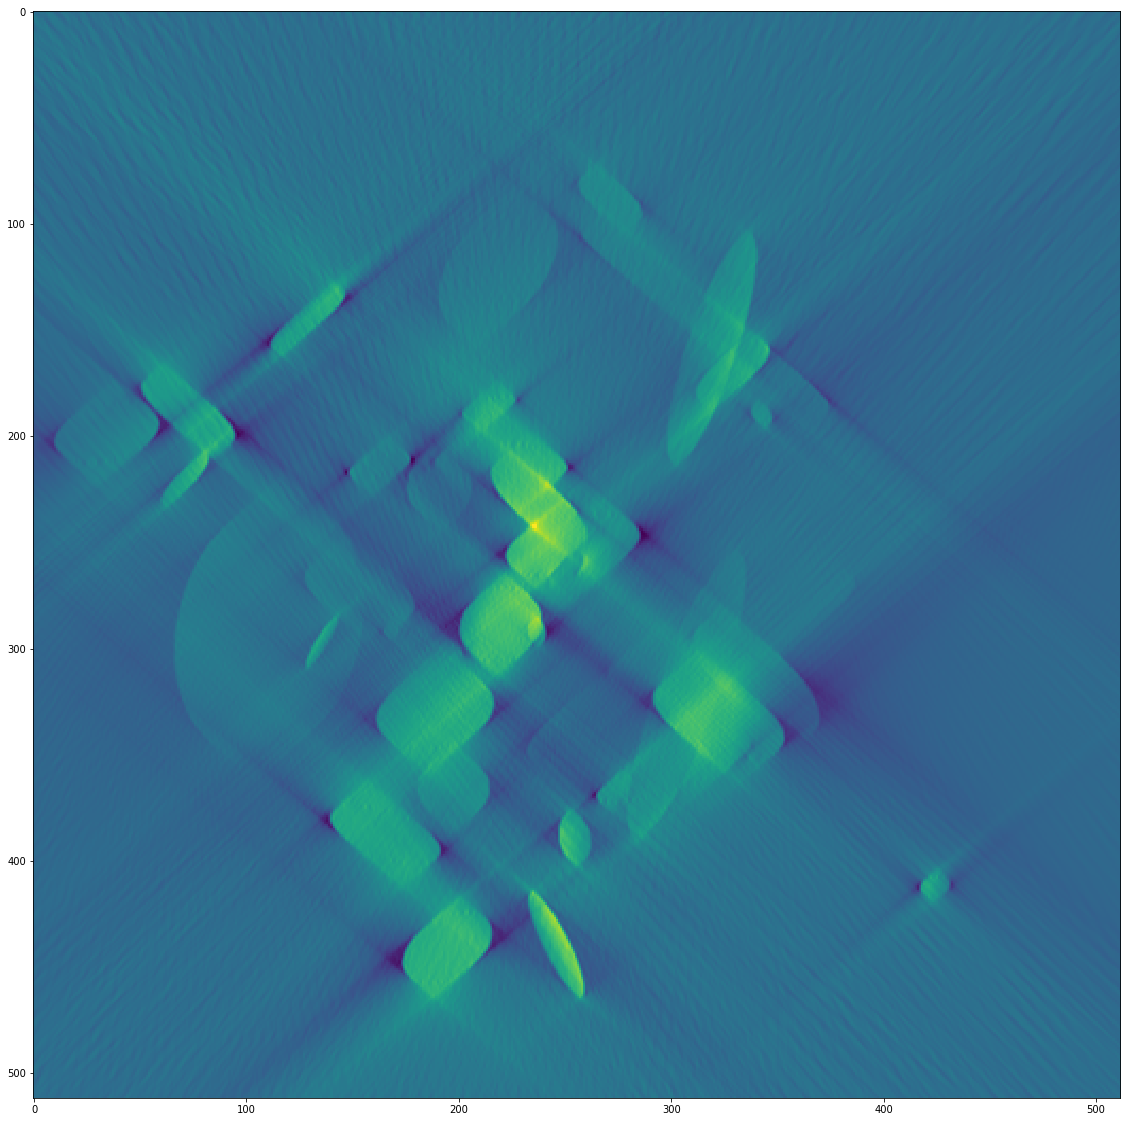

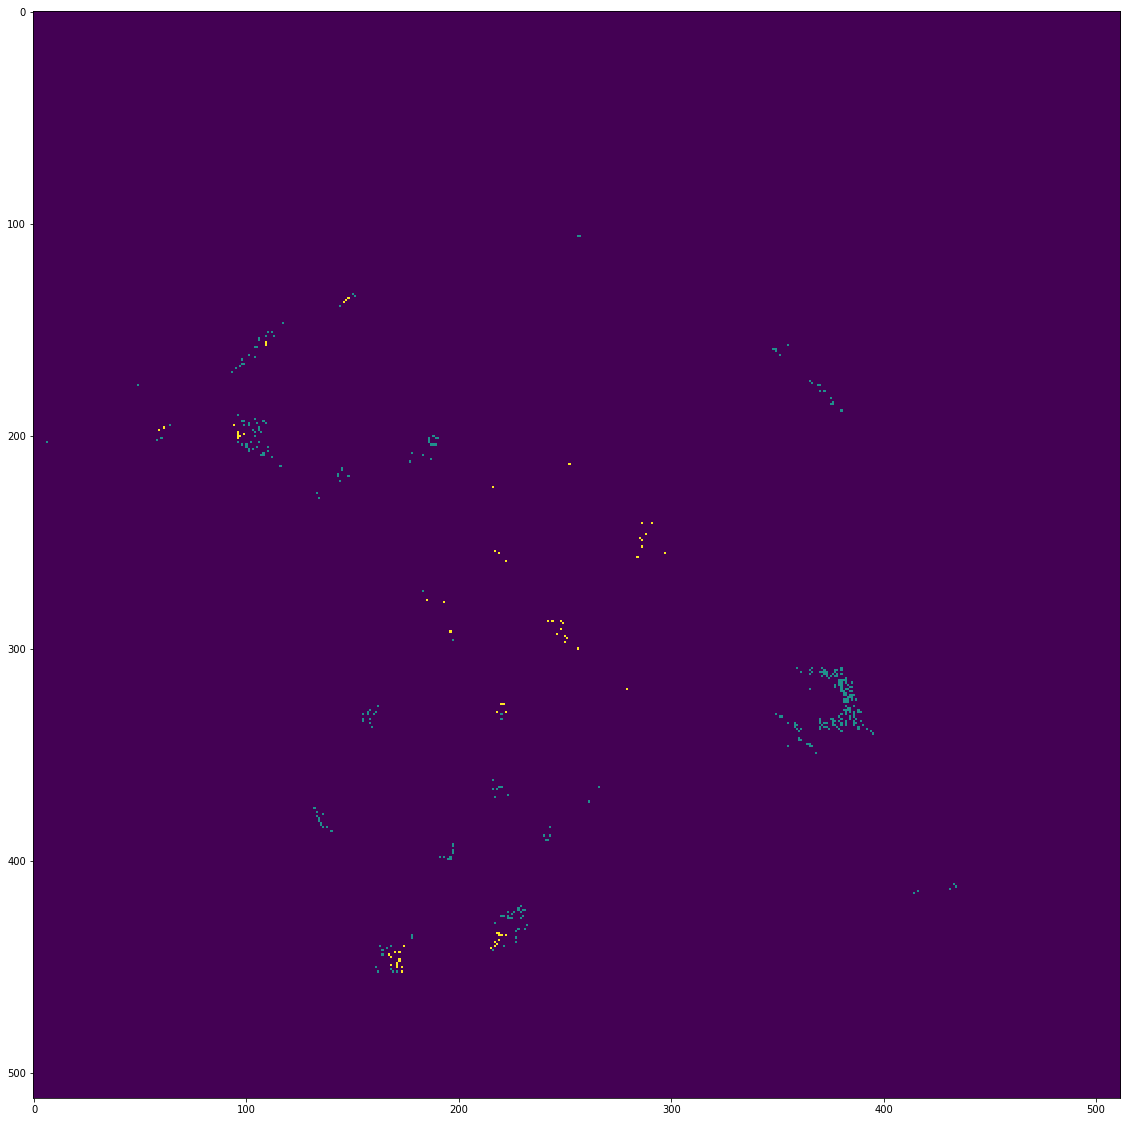

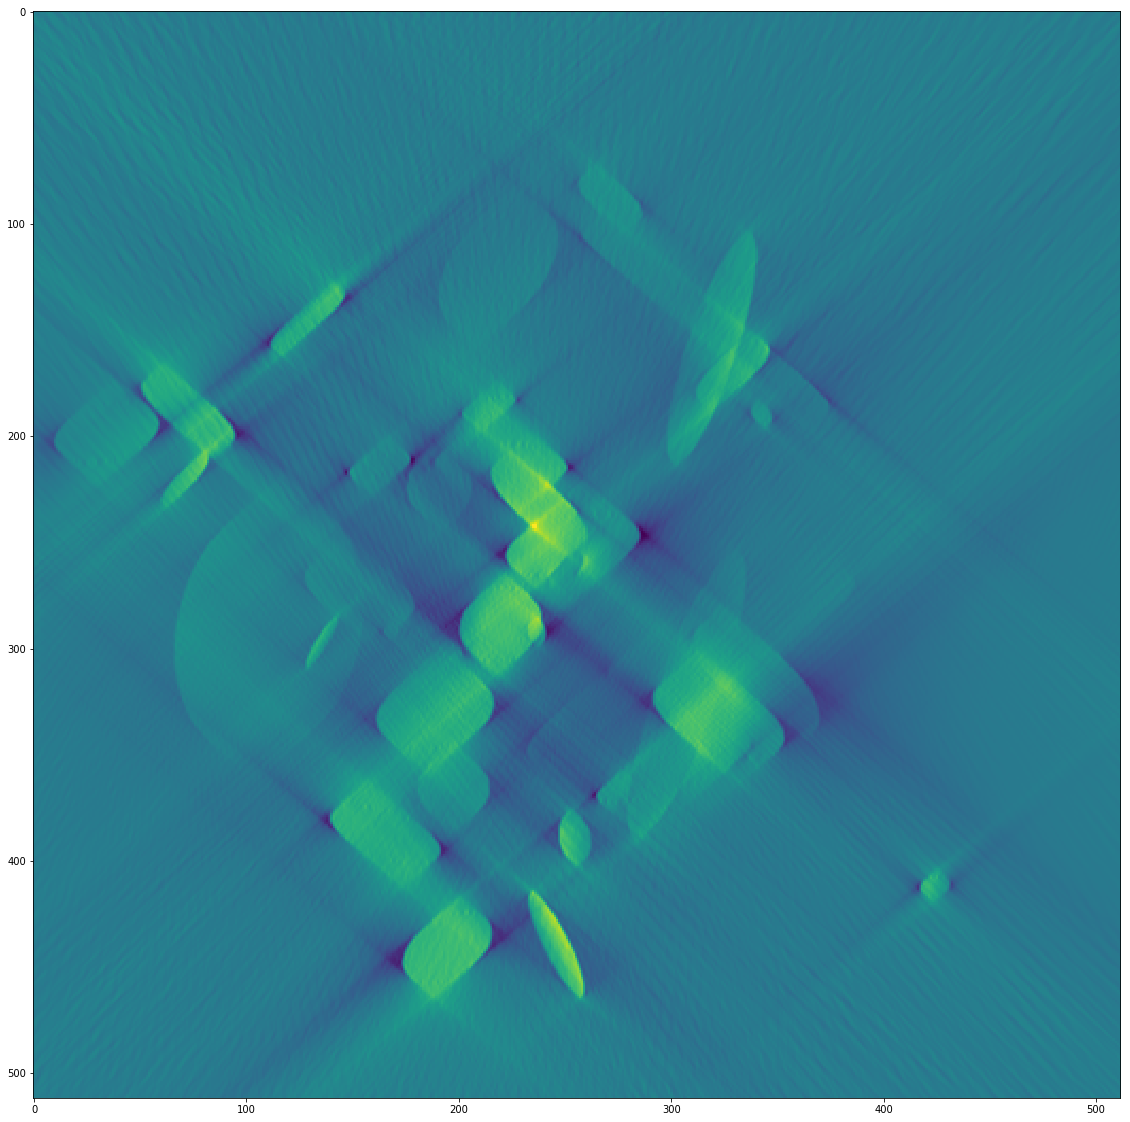

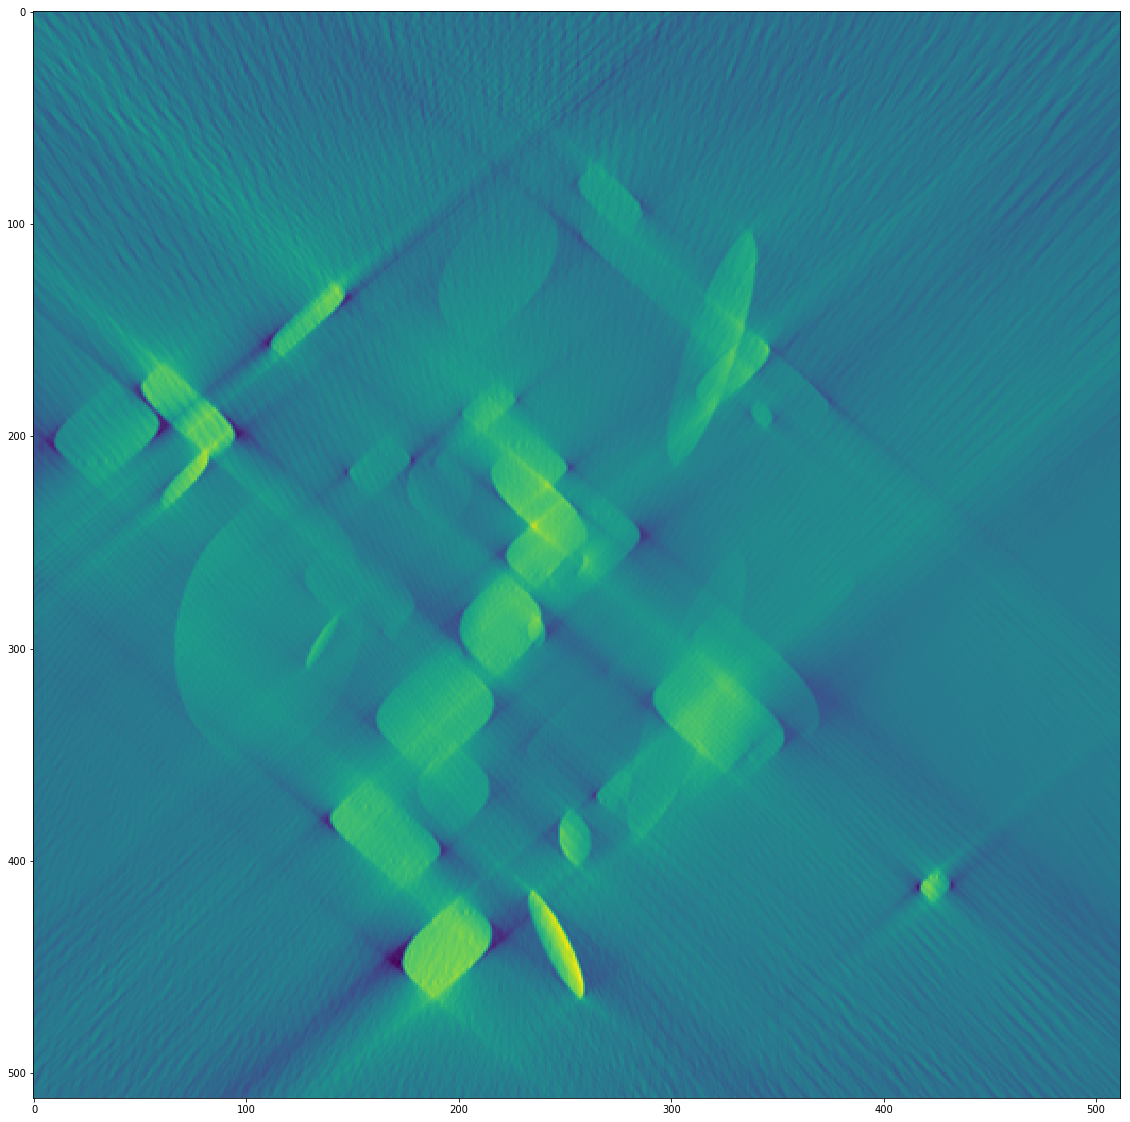

In [14]:
for im in a:
    plt.figure(figsize=(20,20))
    plt.imshow(np.squeeze(im))
    plt.show()

In [15]:
for im in a:
    print(np.amax(im), np.amin(im))

65535.0 0.0
65535.0 -3.637978807091713e-12
3.637978807091713e-12 0.0
32688.464375000003 -32592.075625
4.697905859848841 -5.540261736162776


In [11]:
print(np.array_equal(X_normal, X_demeaned_normalized*X_train_std + X_train_mean))

False


In [17]:
print(np.amax(refs_train[0]), np.amin(refs_train[0]))
print(np.amax(mean_out_train[0]), np.amin(mean_out_train[0]))

12.867002216553406 -1.8297920344342813
1.8526264 -2.2292373


1.8526264 -2.2292373


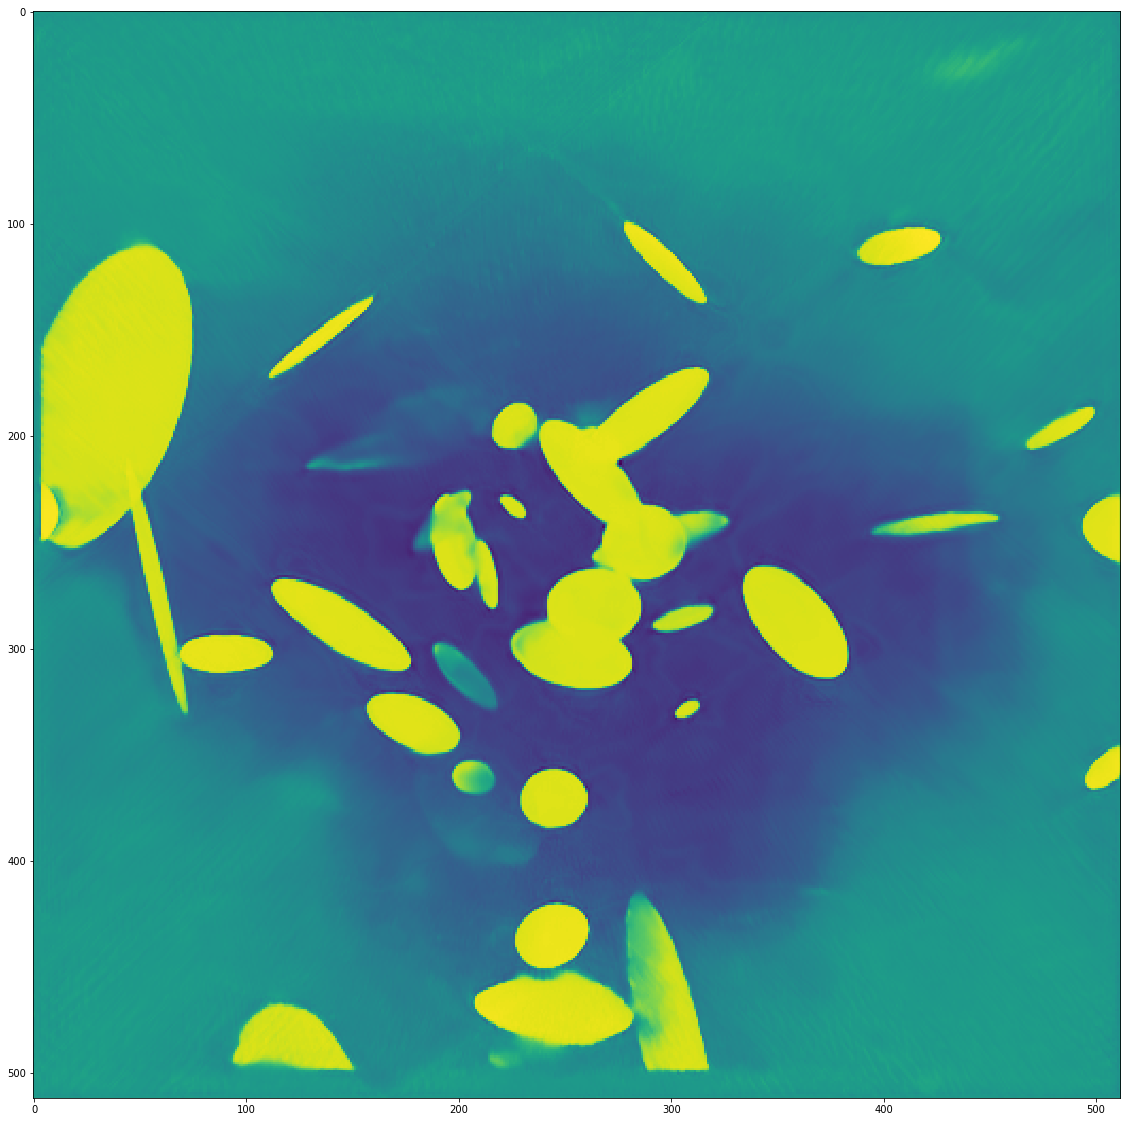

12.867002216553406 -1.8297920344342813


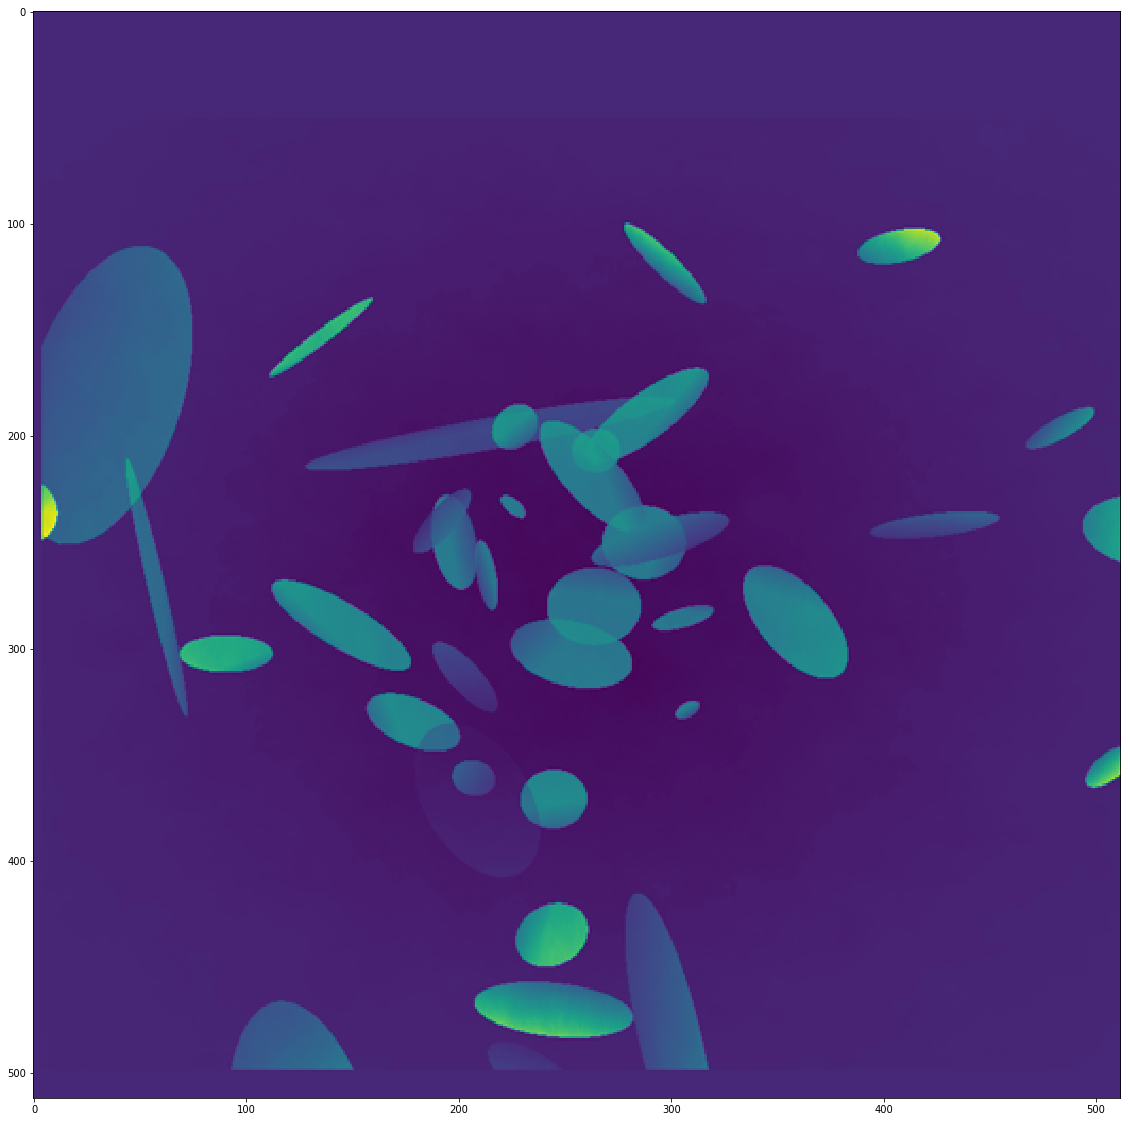

1.9281832 -1.6793225


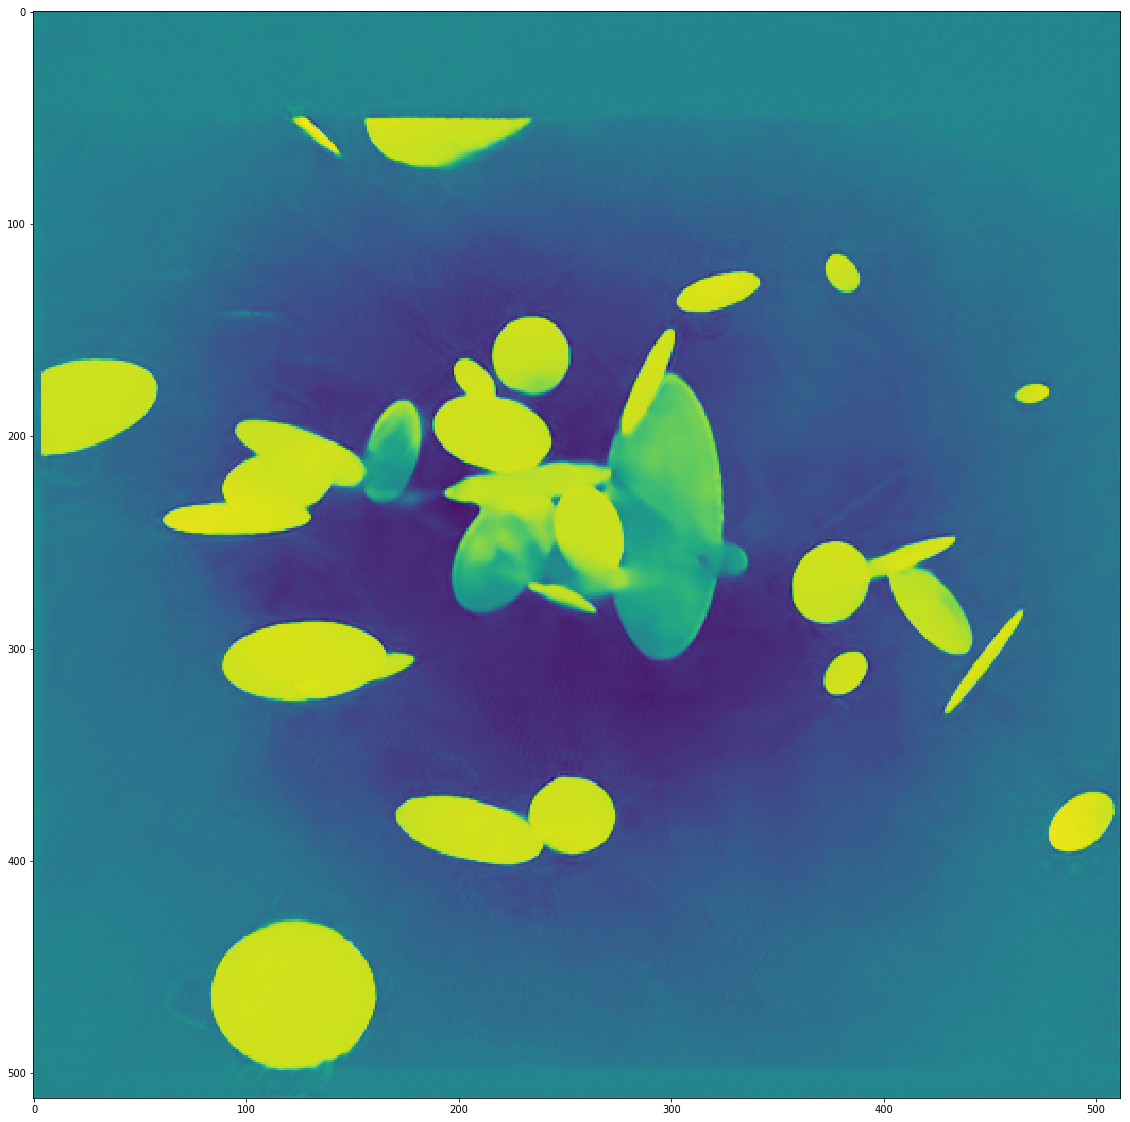

14.603235905714795 -1.749017483650834


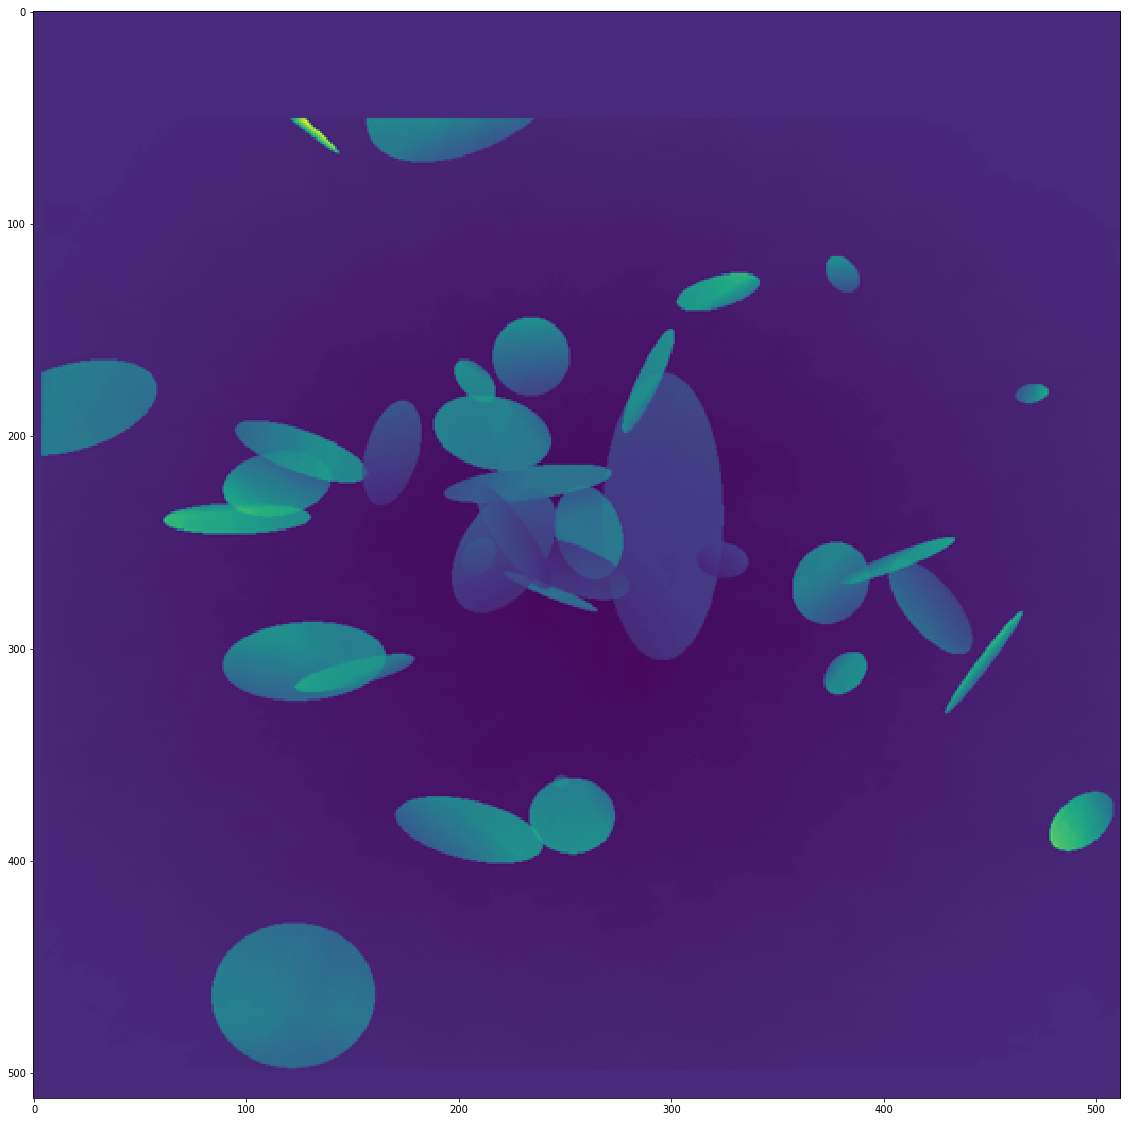

1.9501861 -1.3289495


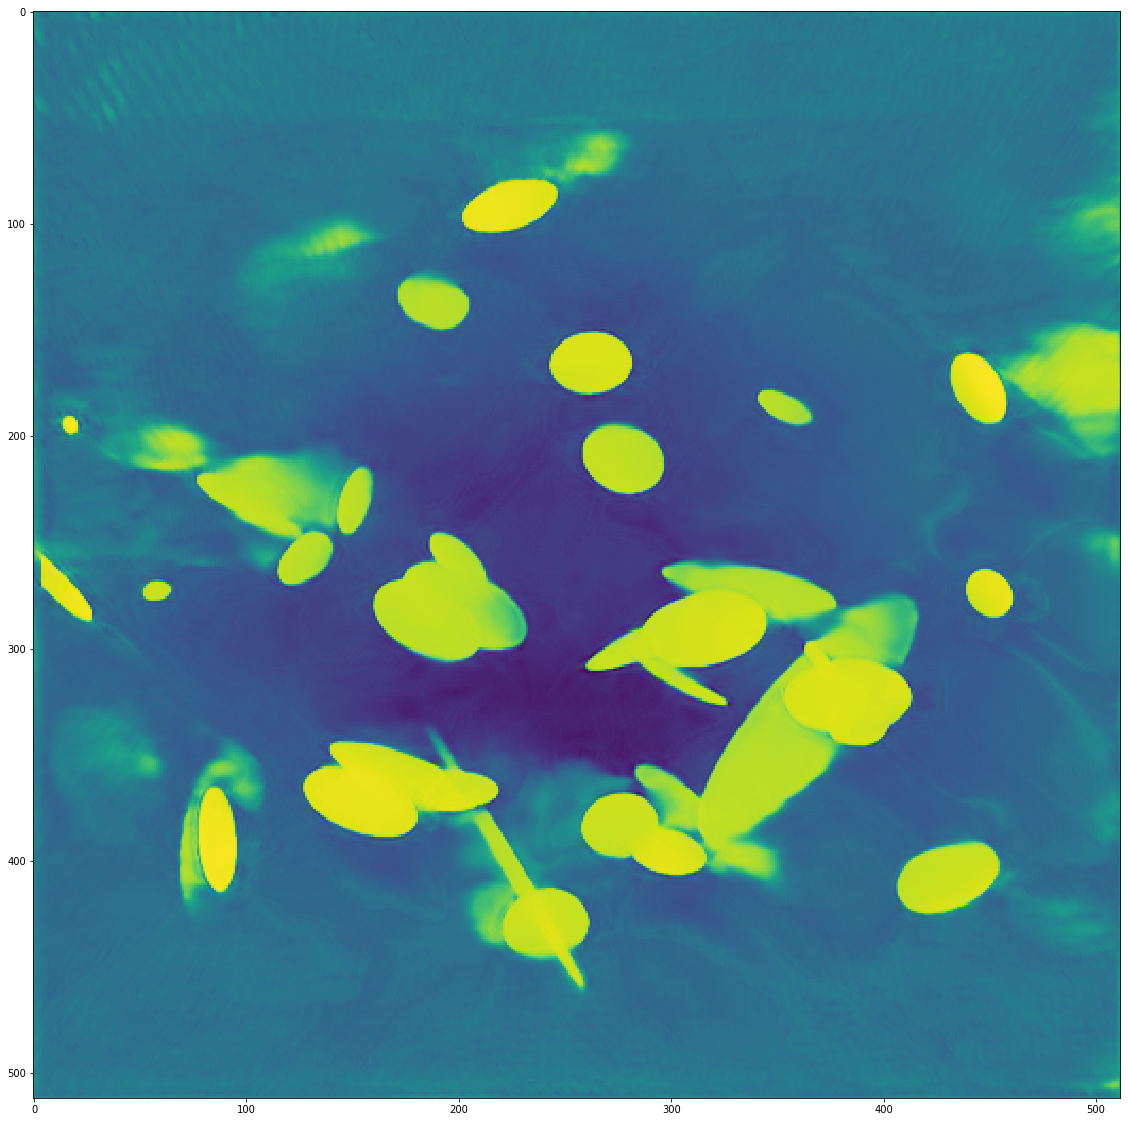

12.85629625564755 -1.8169550793990163


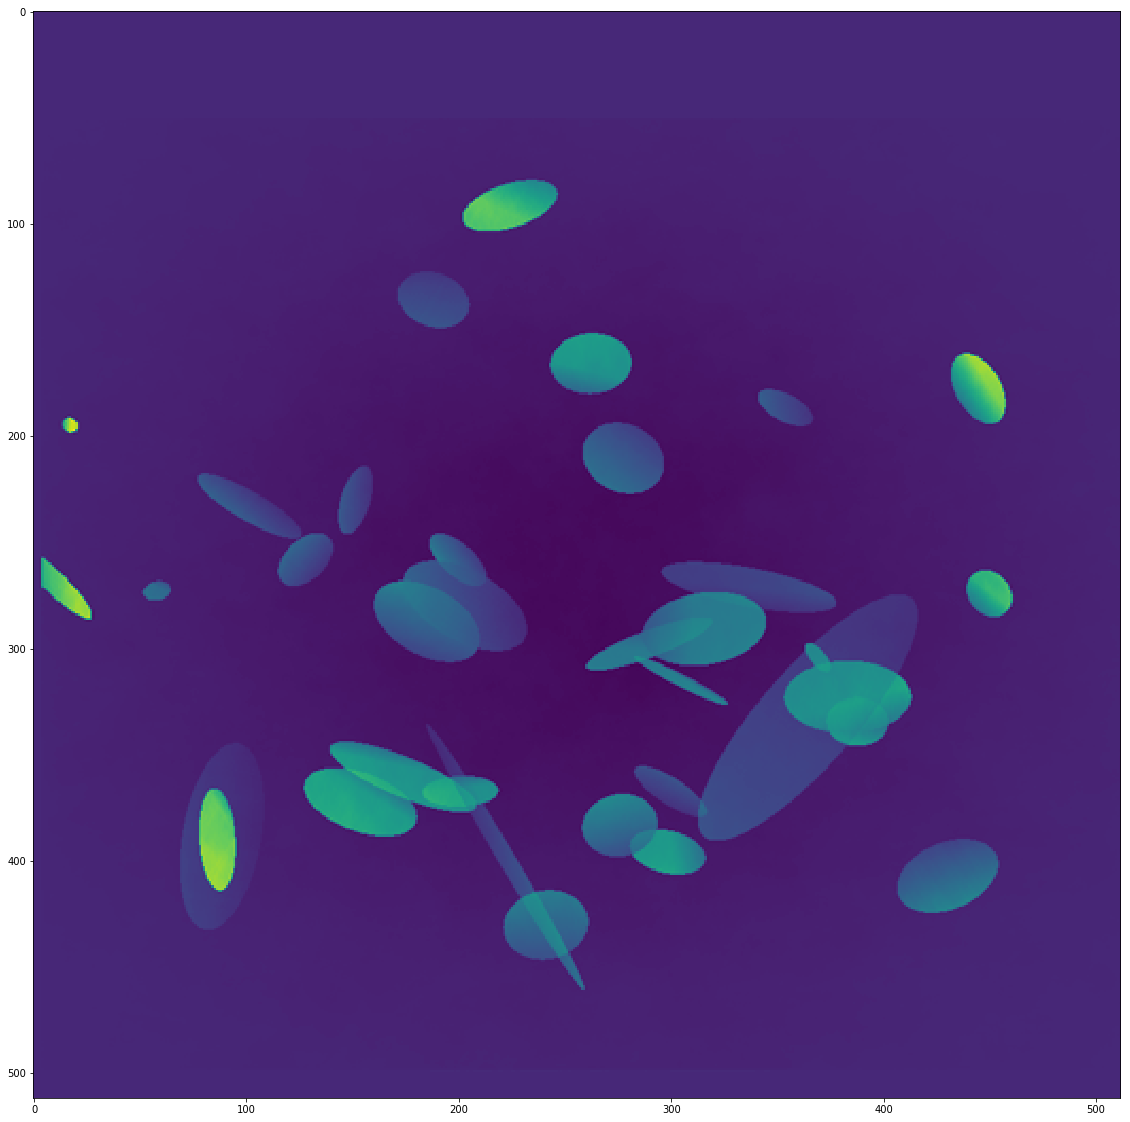

1.9327855 -1.6257062


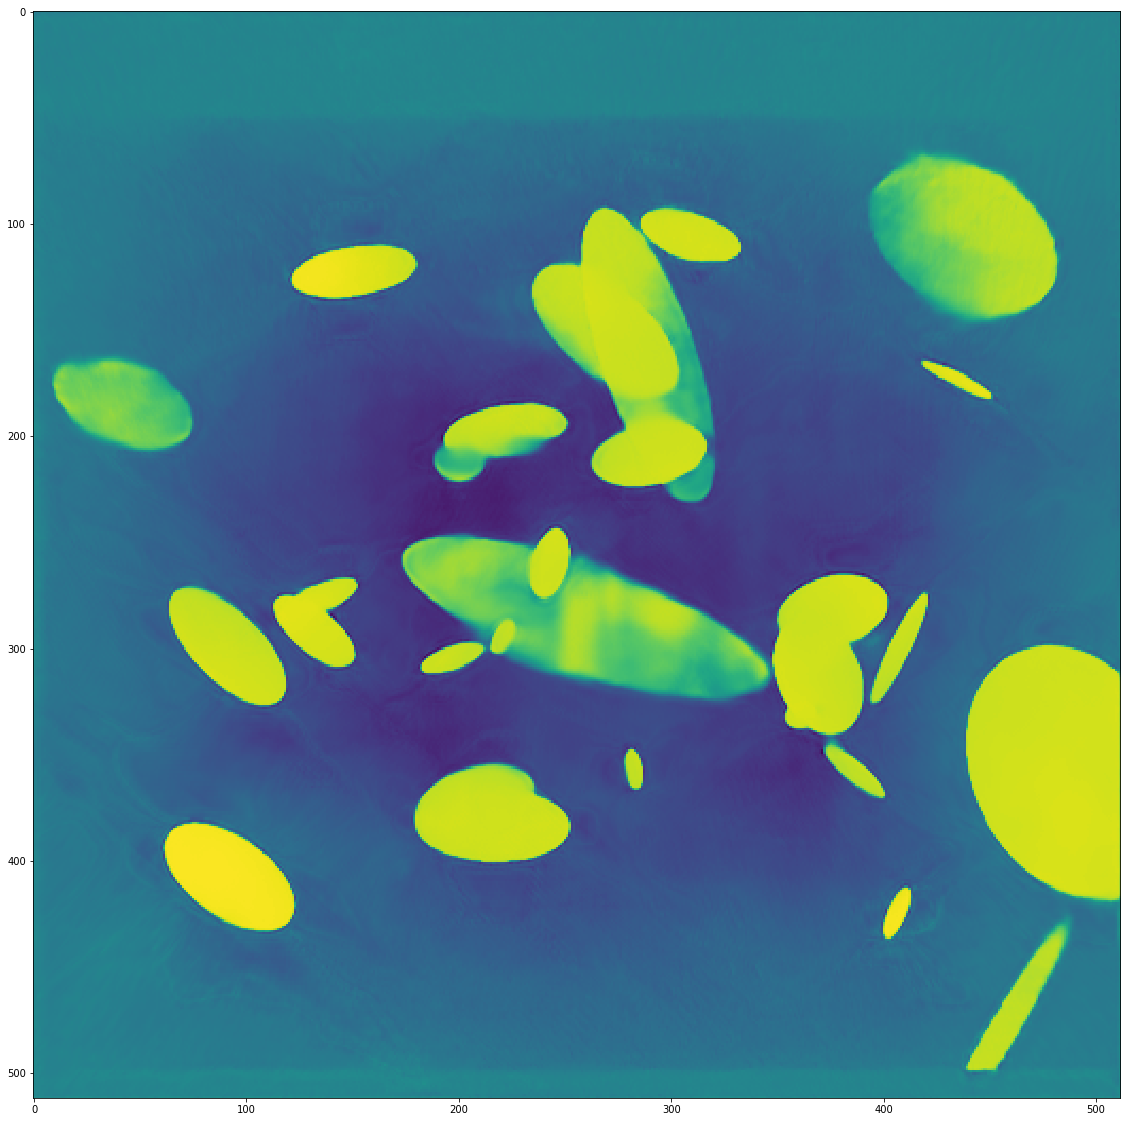

11.96353804027268 -1.7451369091025735


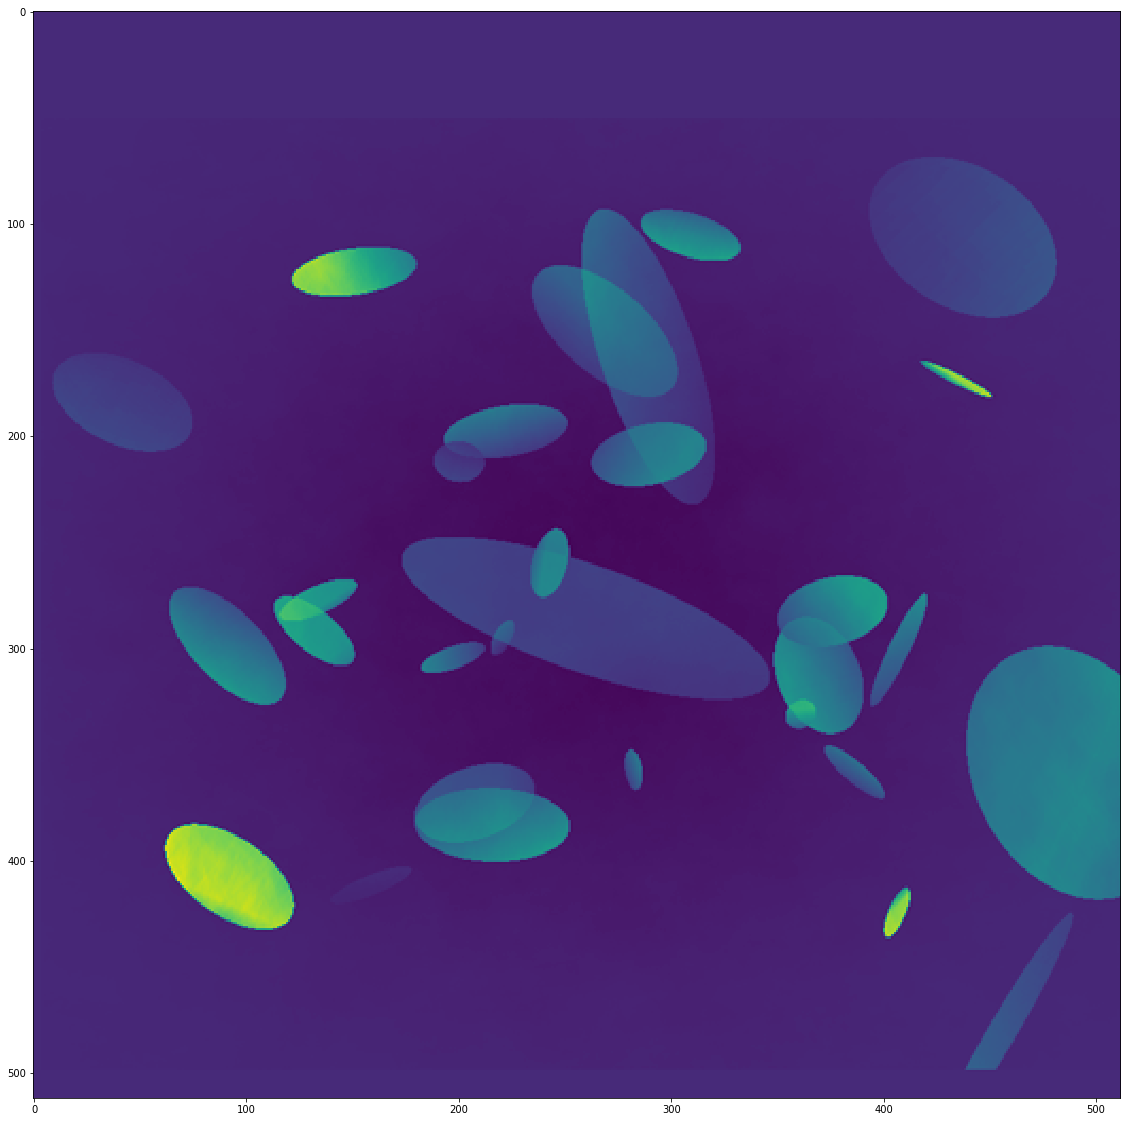

1.8982242 -1.3707047


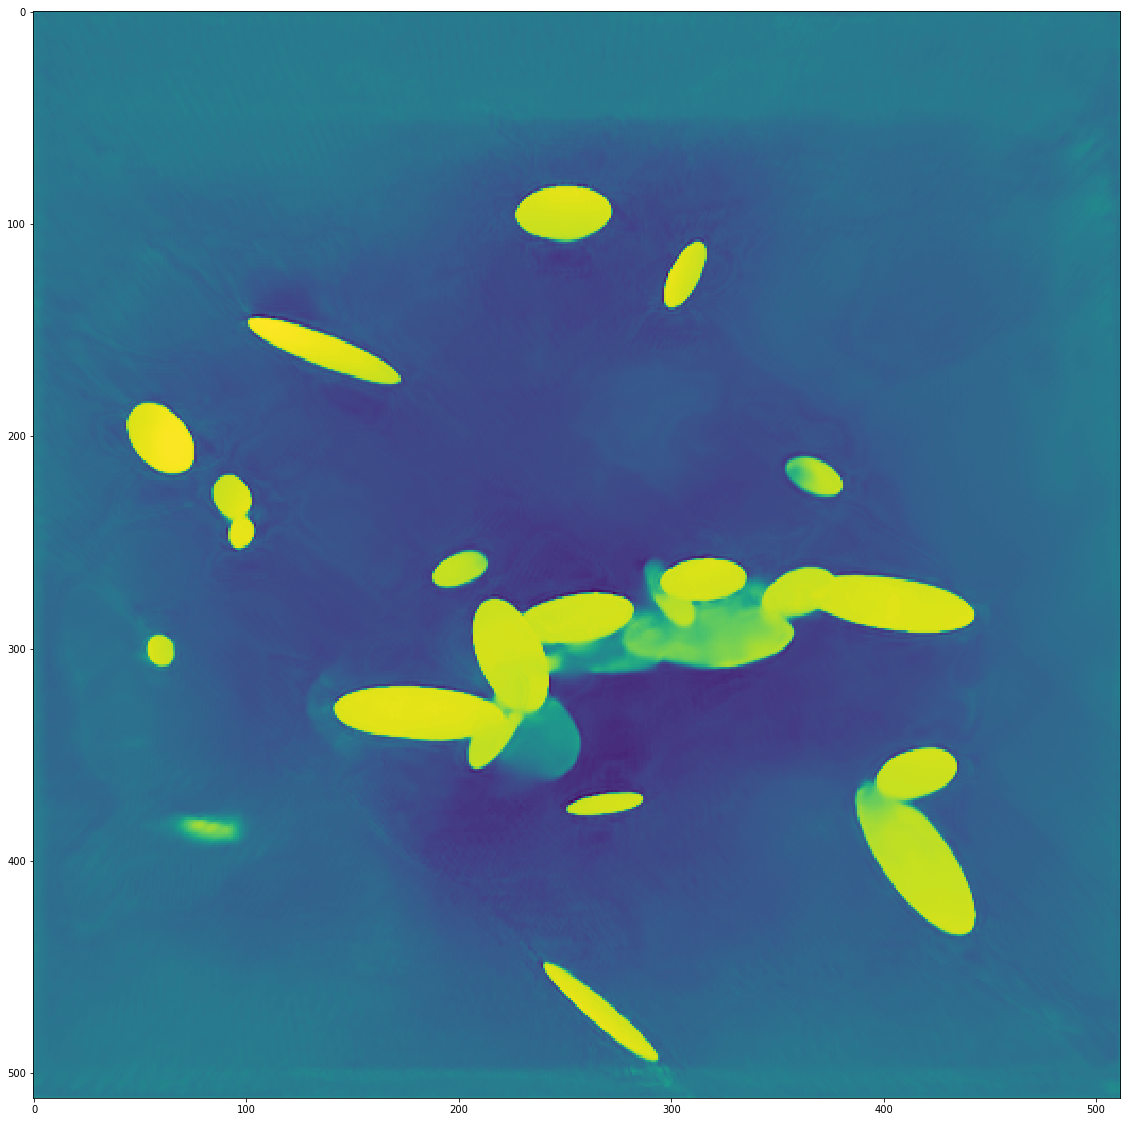

11.550610517631725 -1.6866225040650693


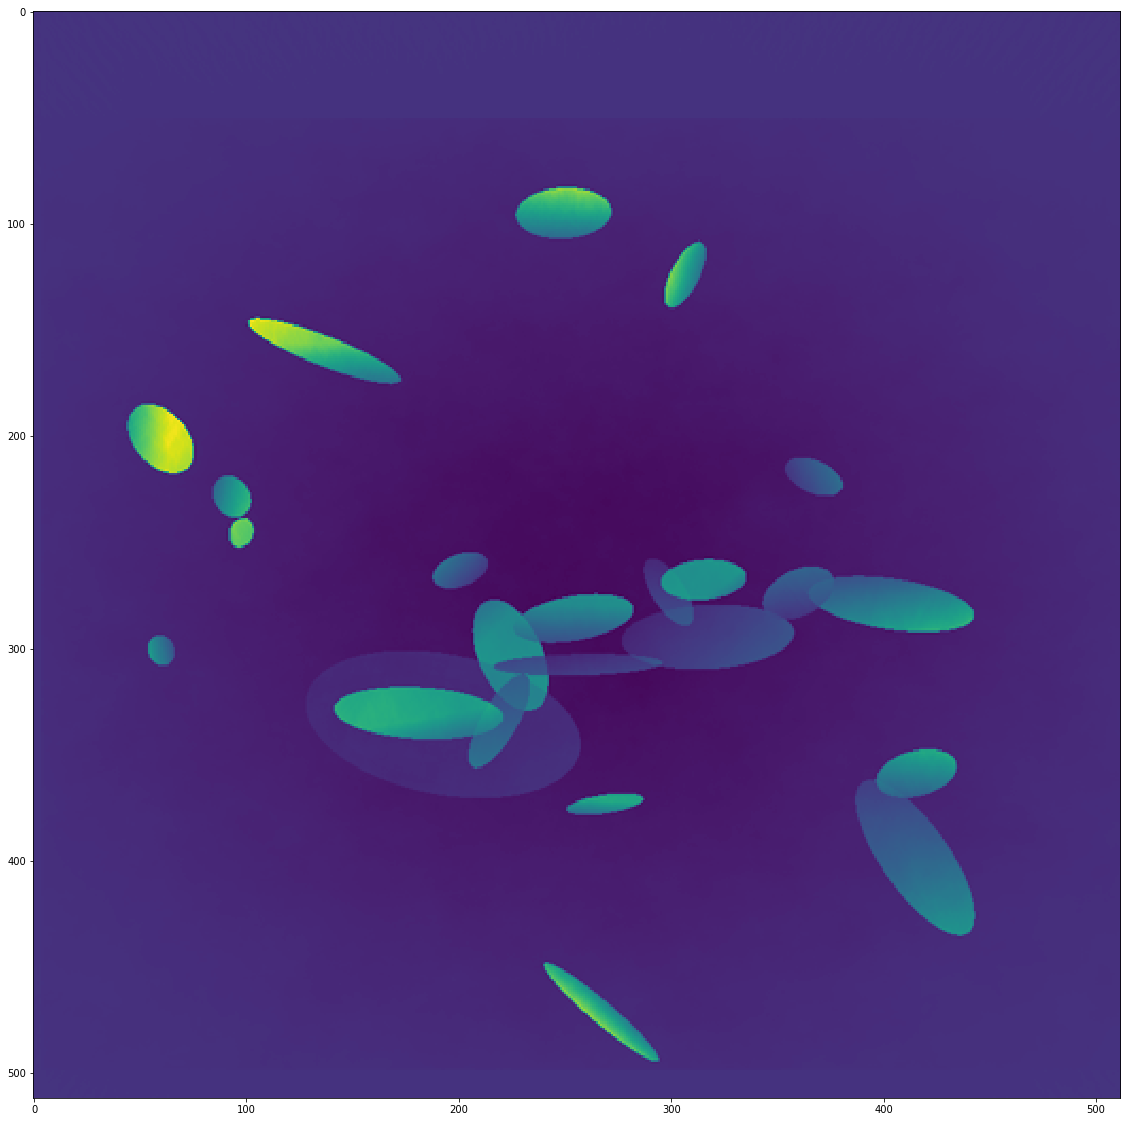

1.9947768 -1.7215466


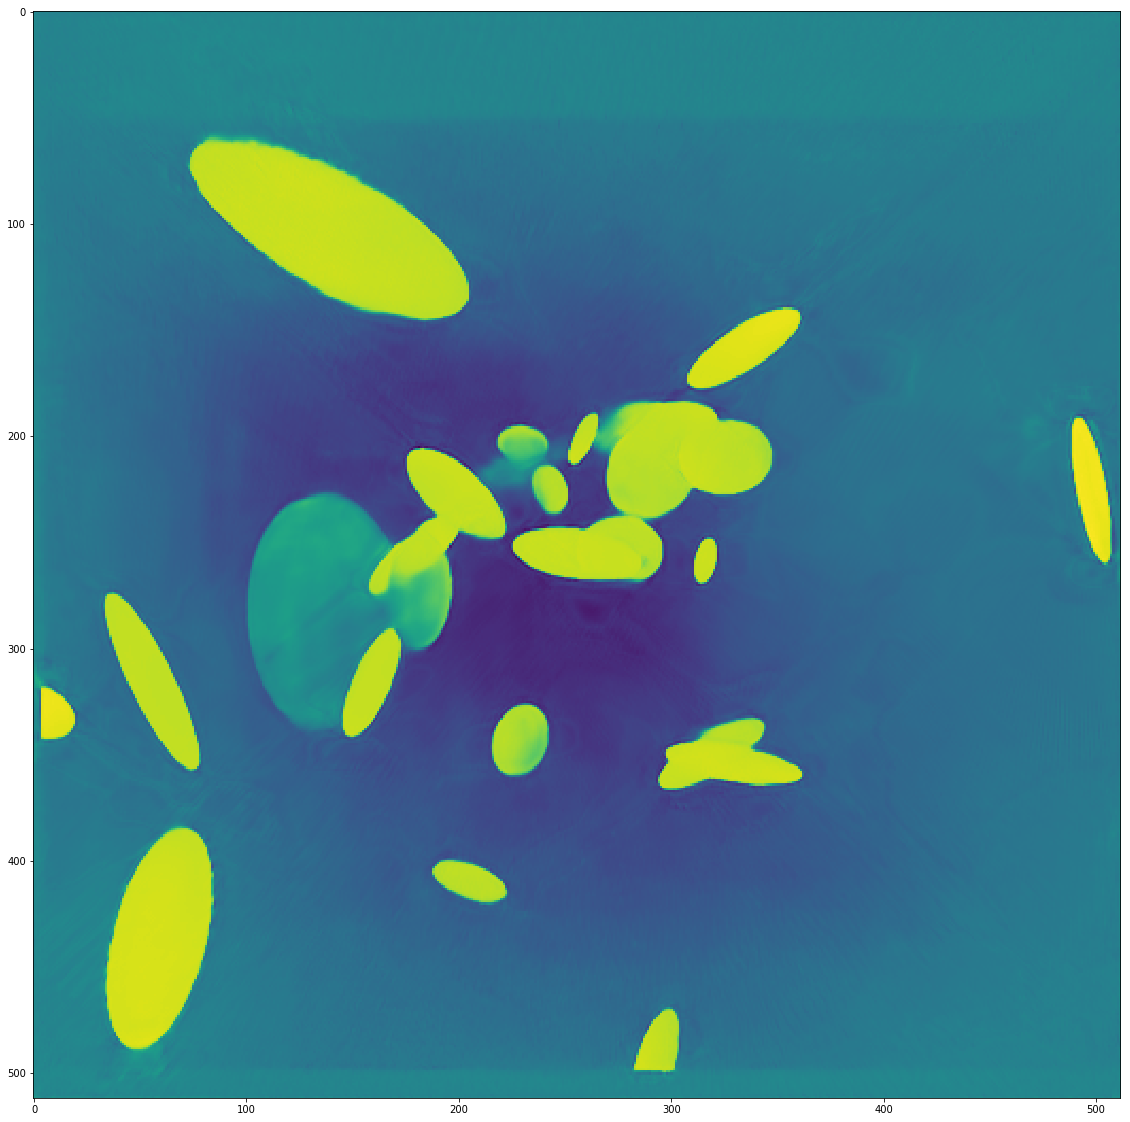

13.056340227364062 -1.71833074993469


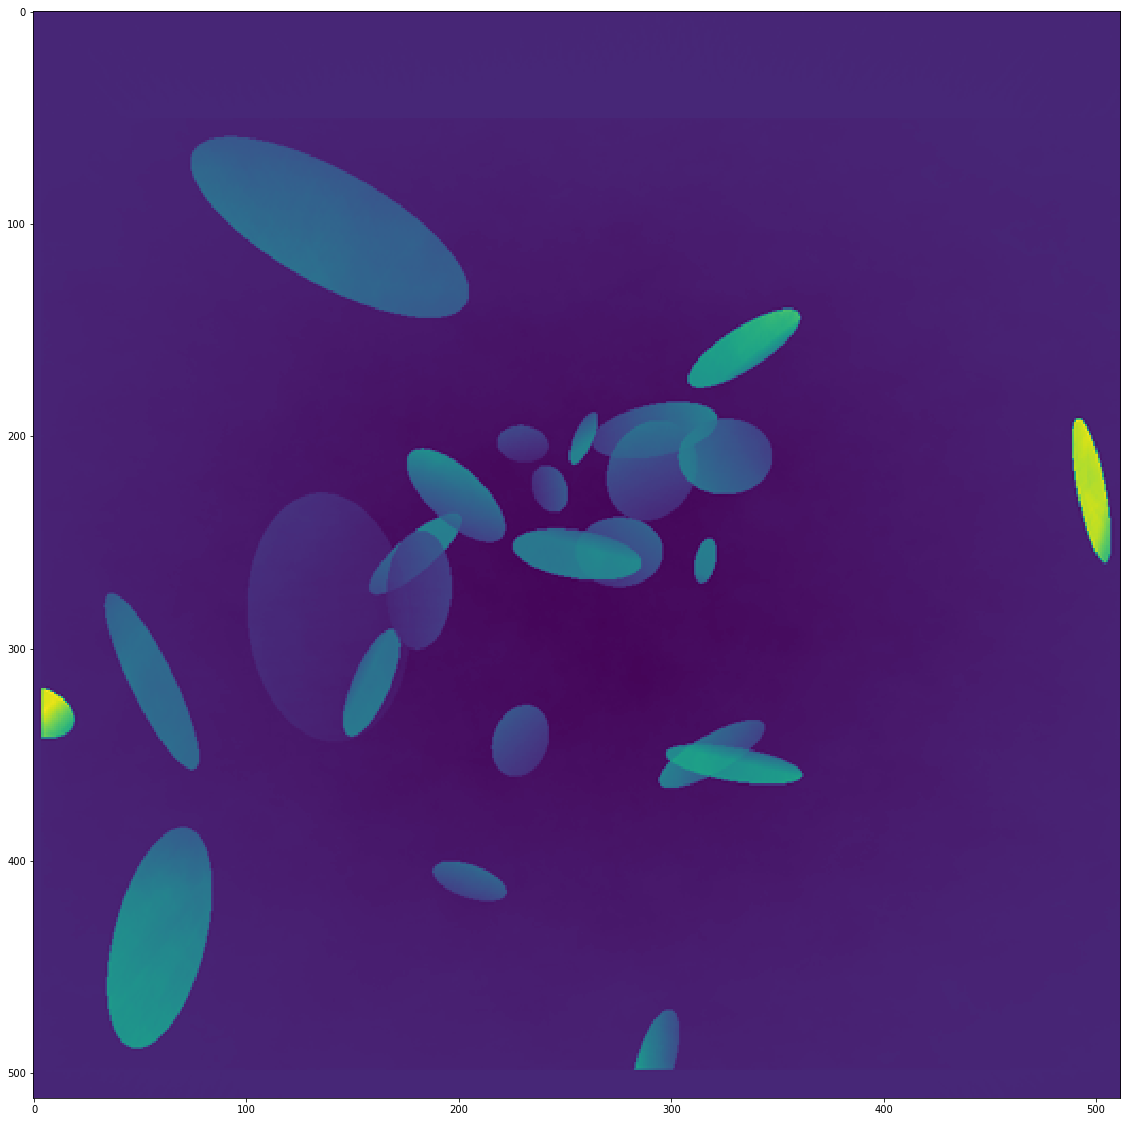

In [19]:
for out,ref in zip(mean_out_train,refs_train):
    
    print(np.amax(out), np.amin(out))
    plt.figure(figsize=(20,20))
    plt.imshow(np.squeeze(out))
    plt.show()
    
    print(np.amax(ref), np.amin(ref))
    plt.figure(figsize=(20,20))
    plt.imshow(np.squeeze(ref))
    plt.show()

1.0 0.0


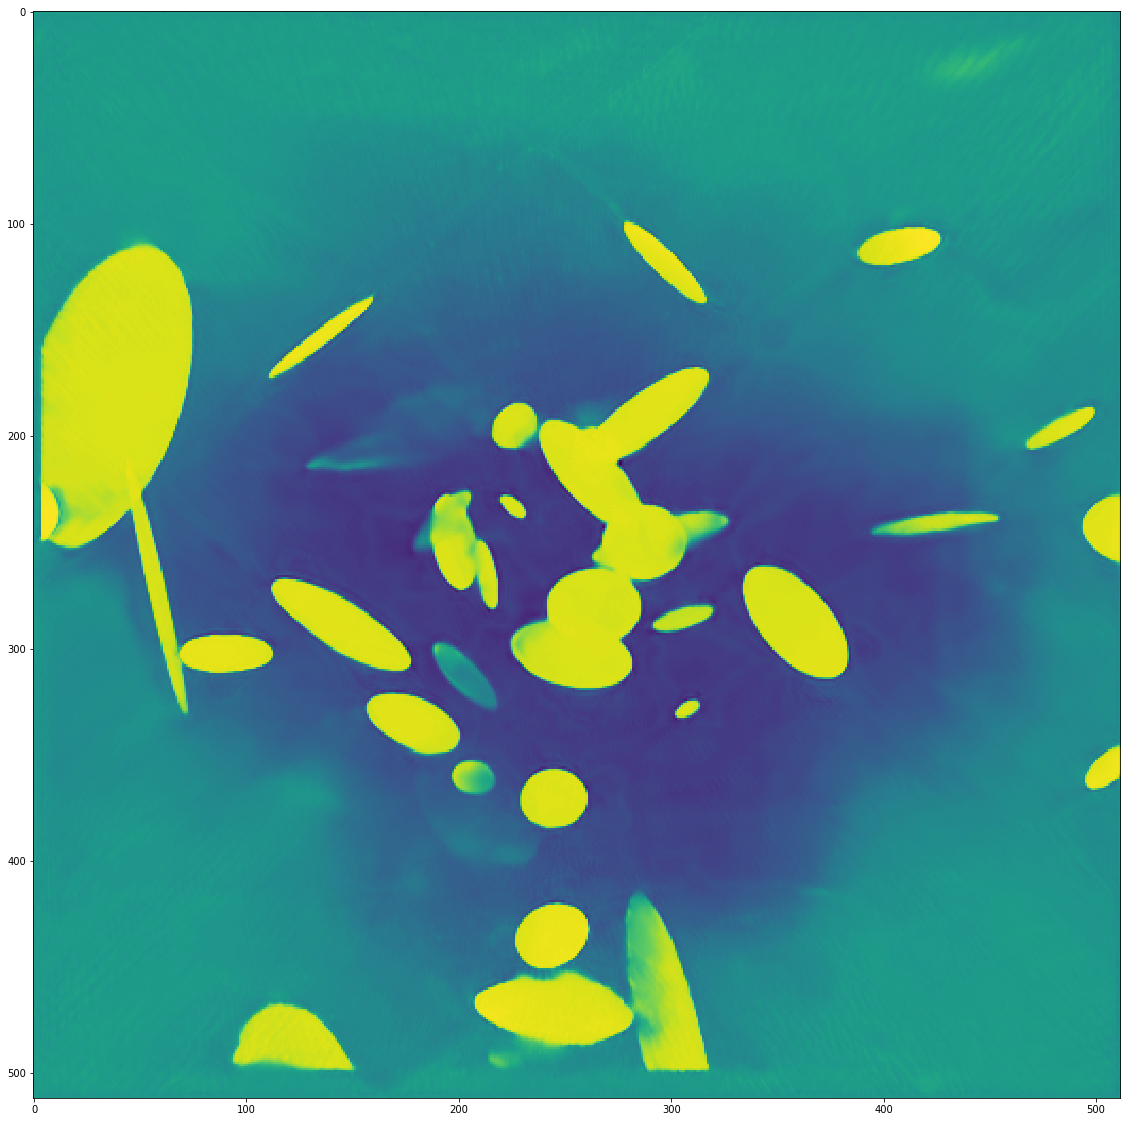

1.0 0.0


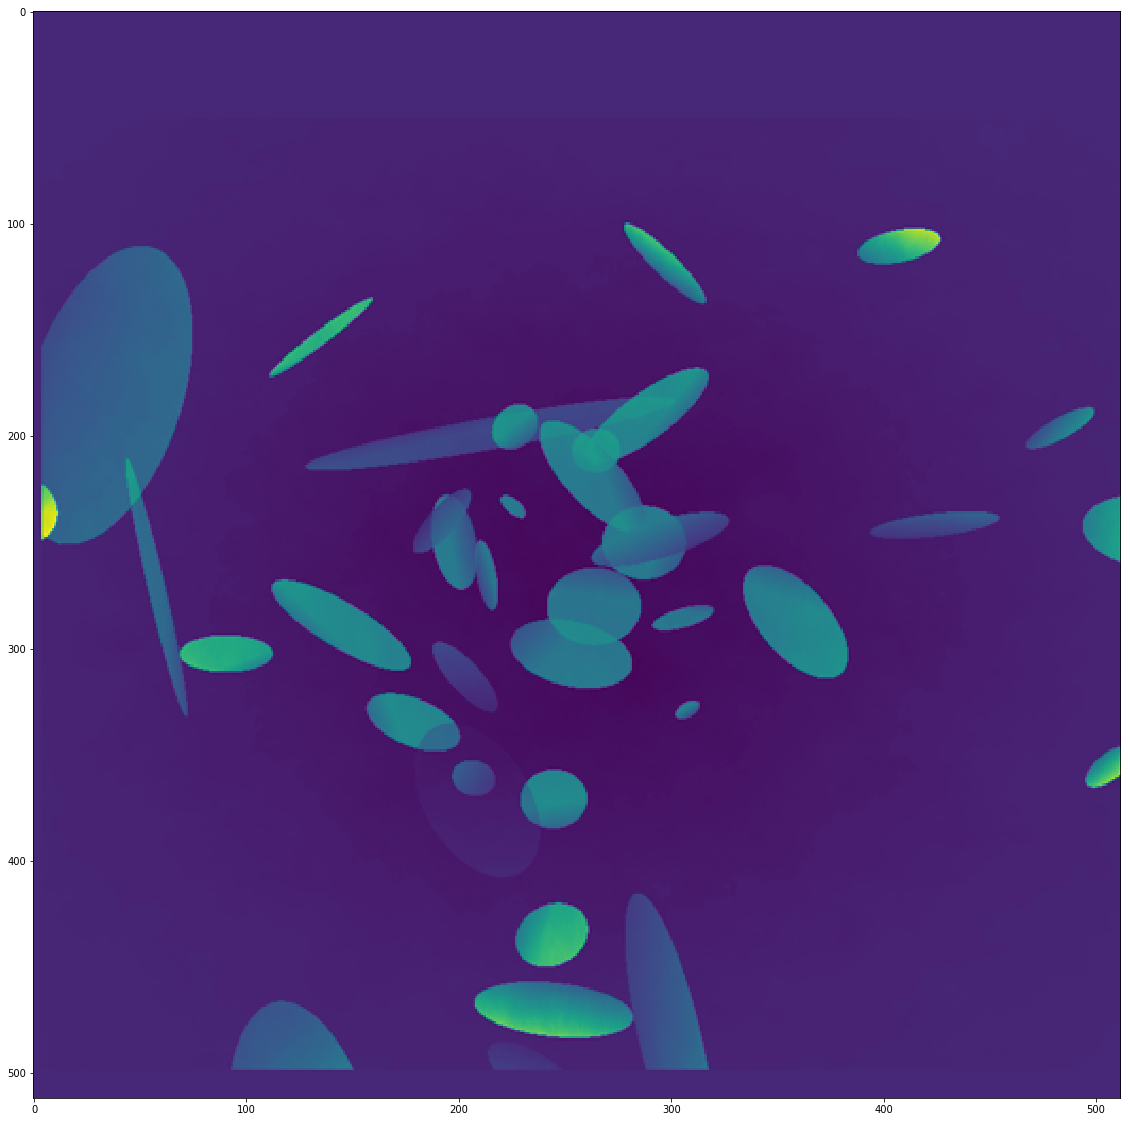

1.0 0.0


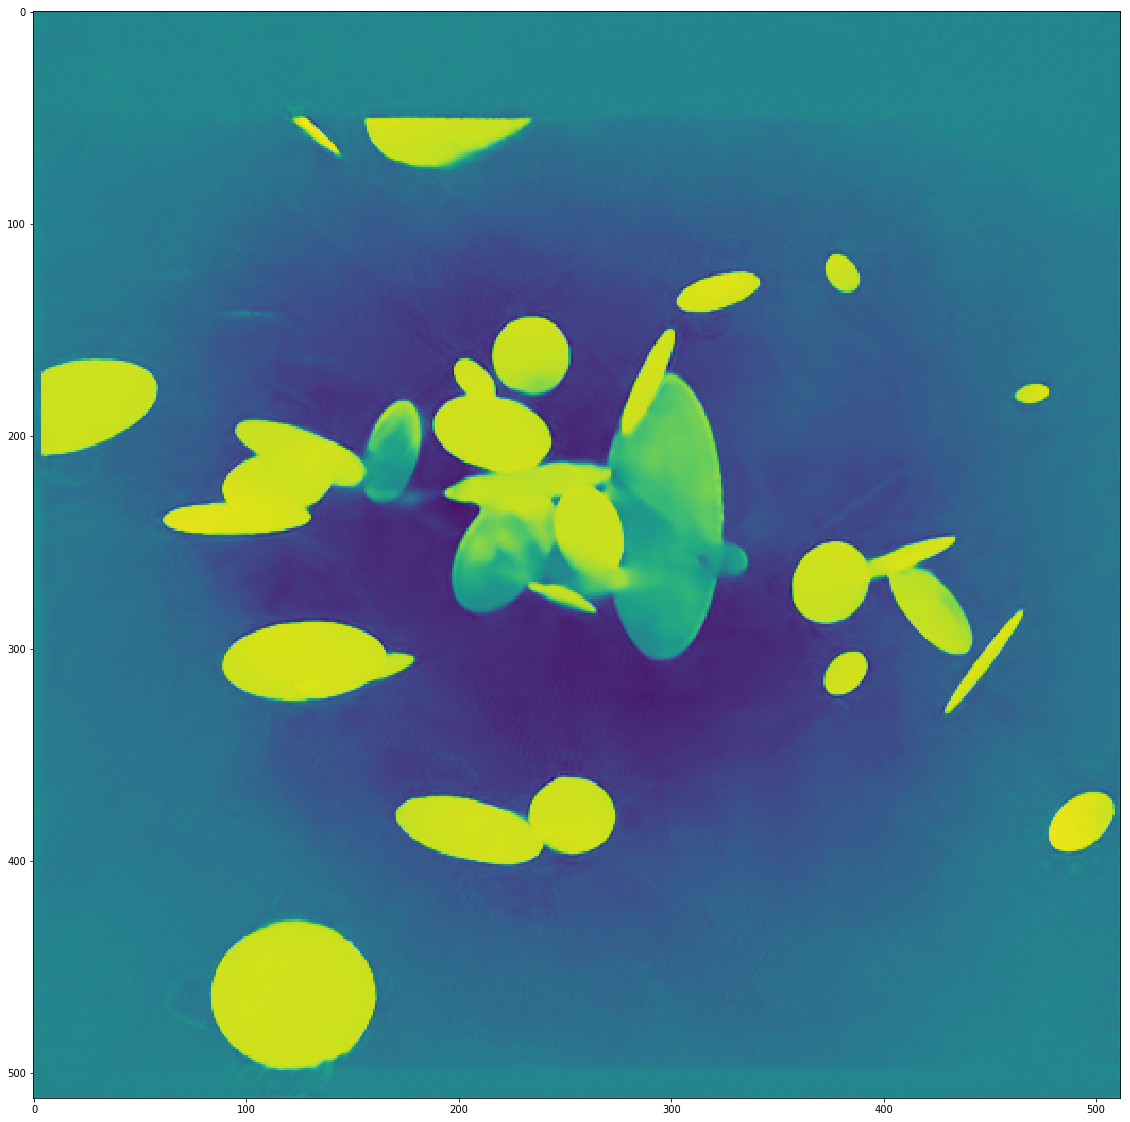

1.0 0.0


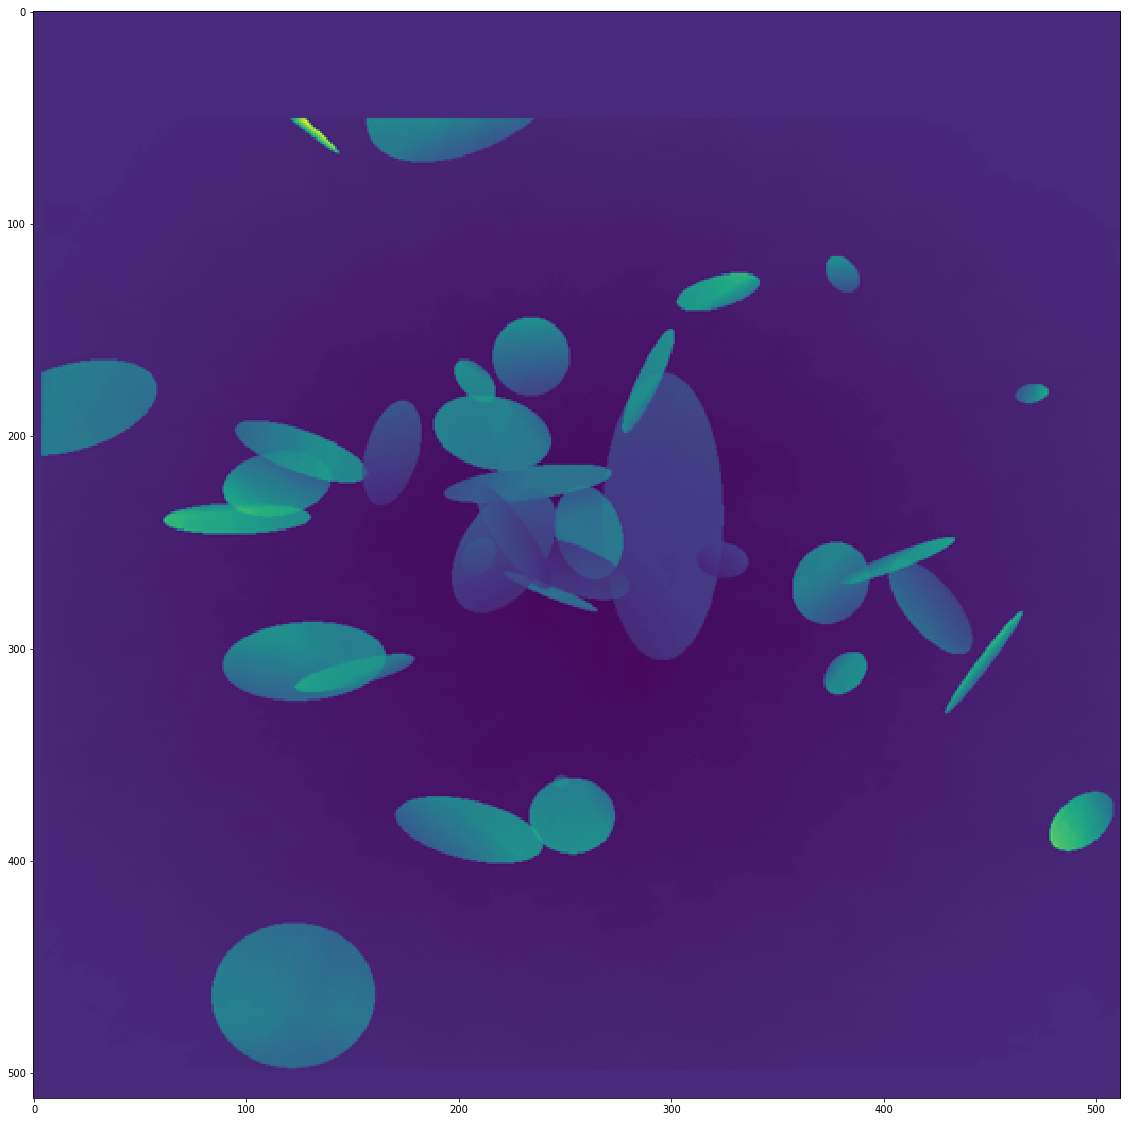

1.0 0.0


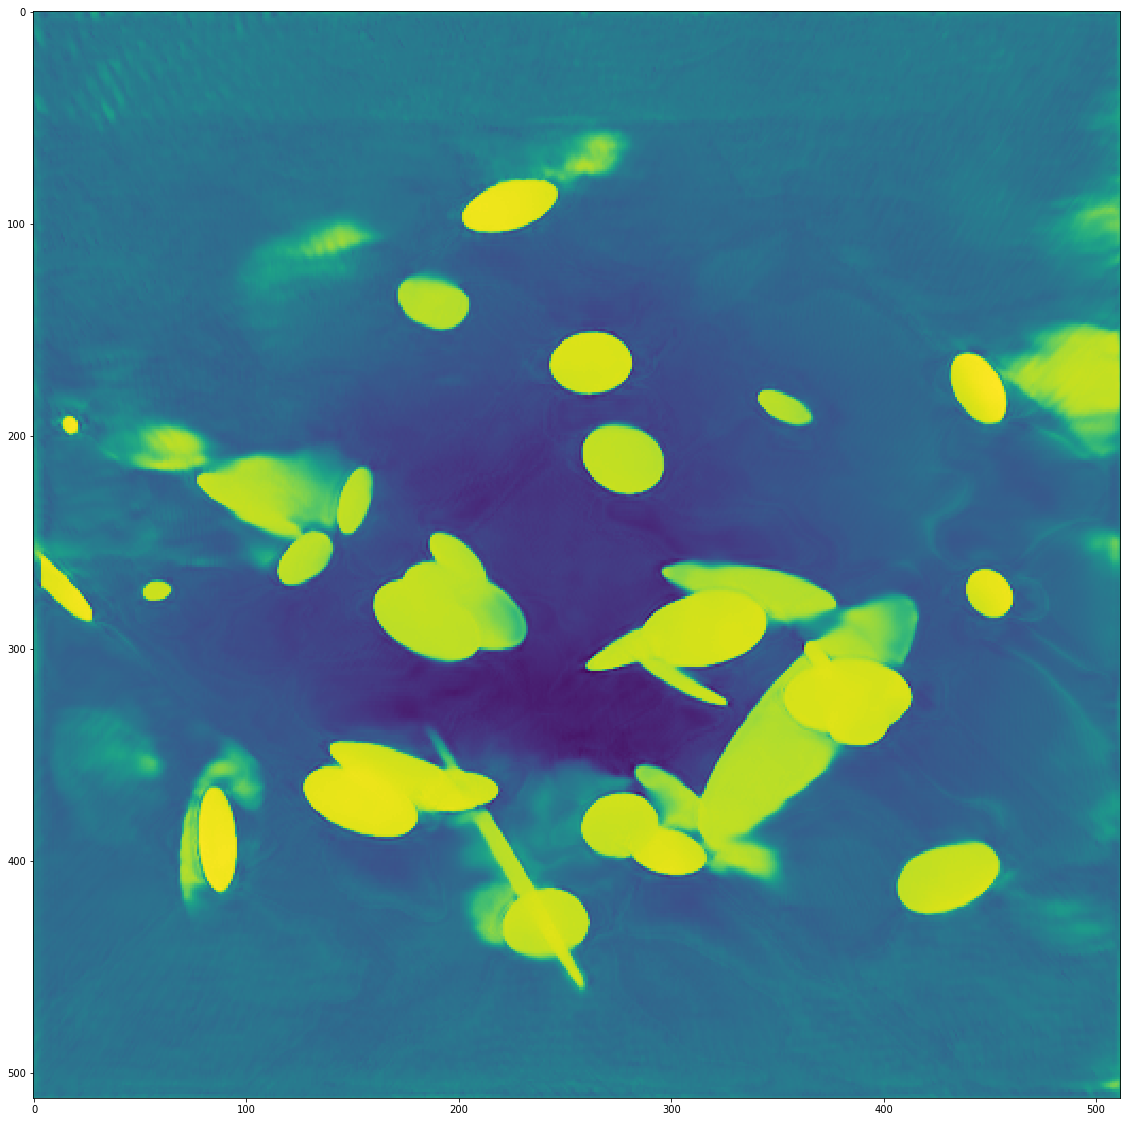

1.0 0.0


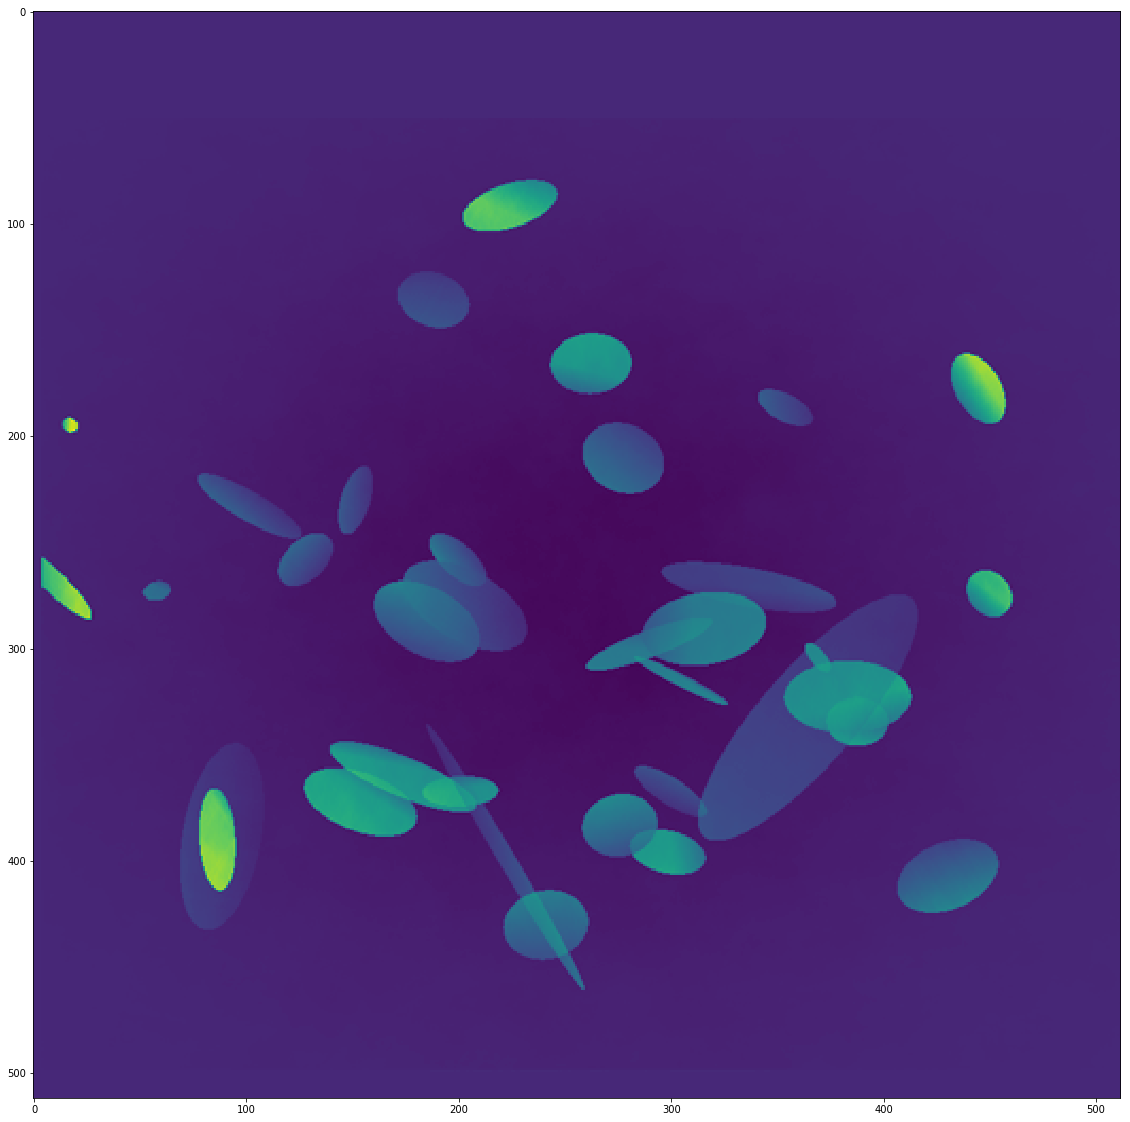

1.0 0.0


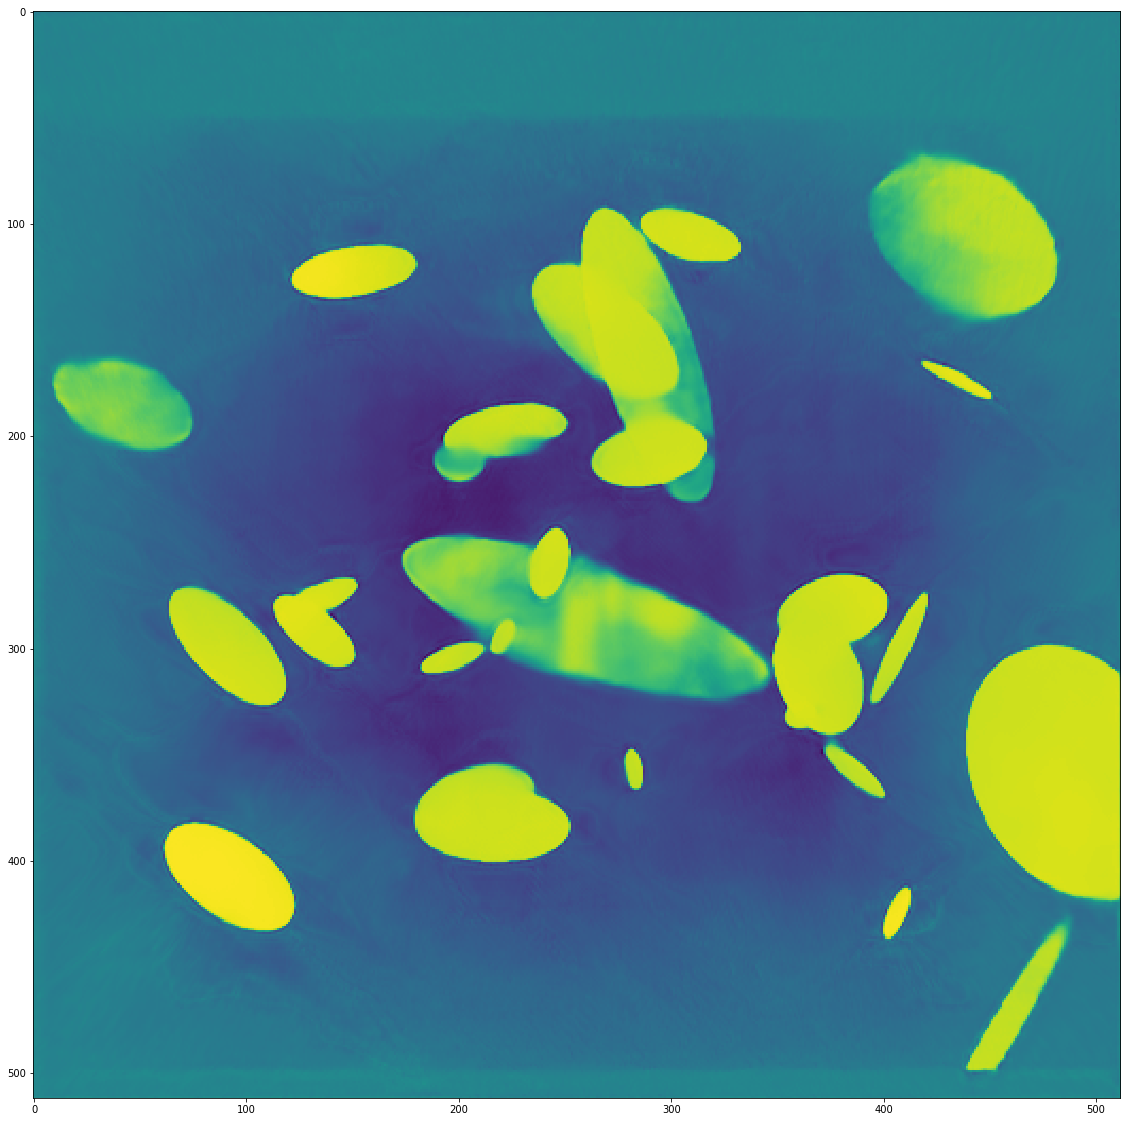

1.0 0.0


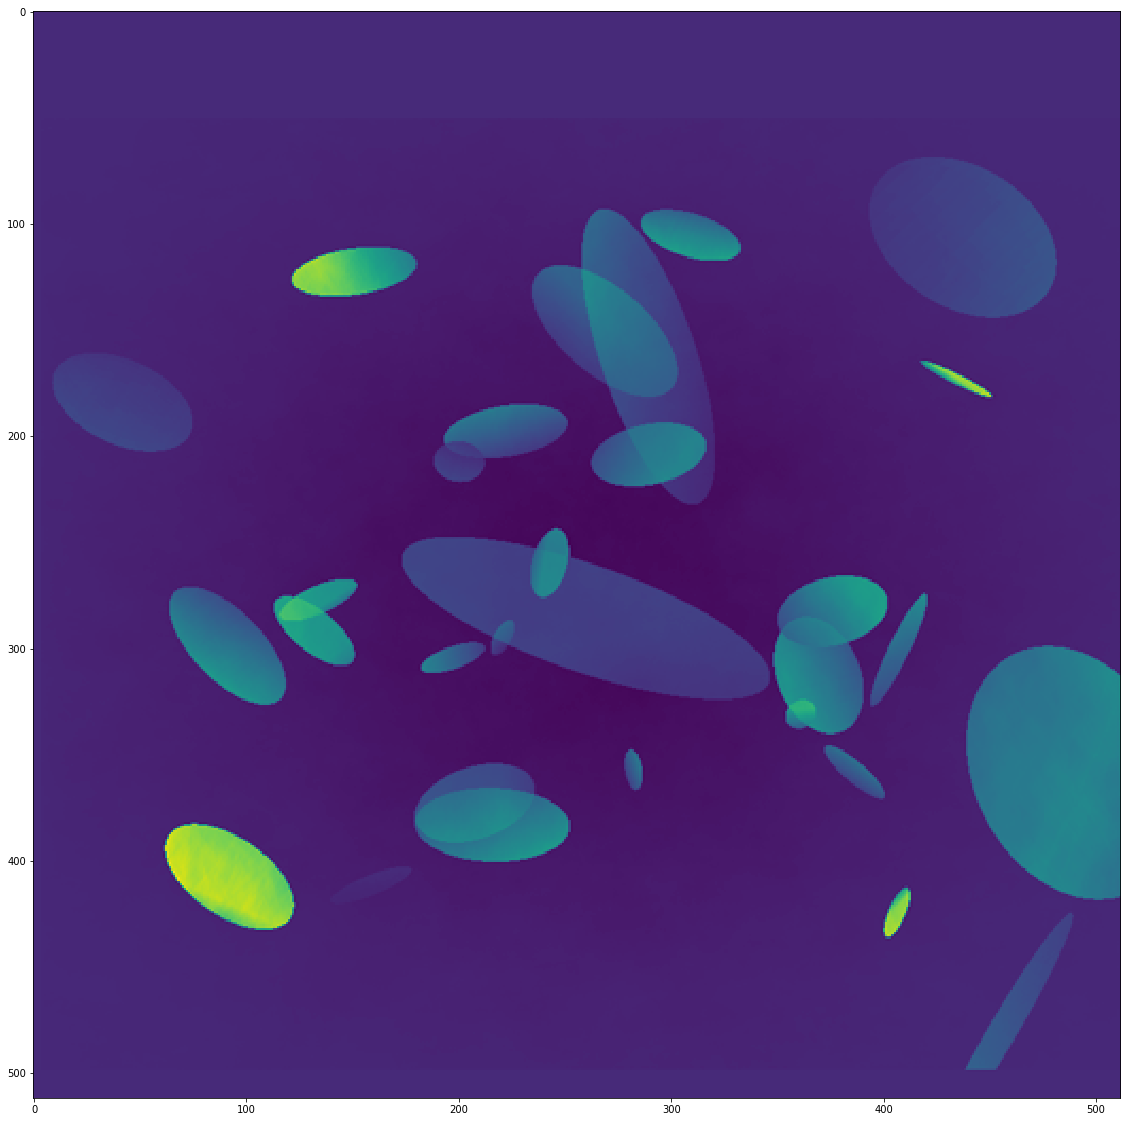

1.0 0.0


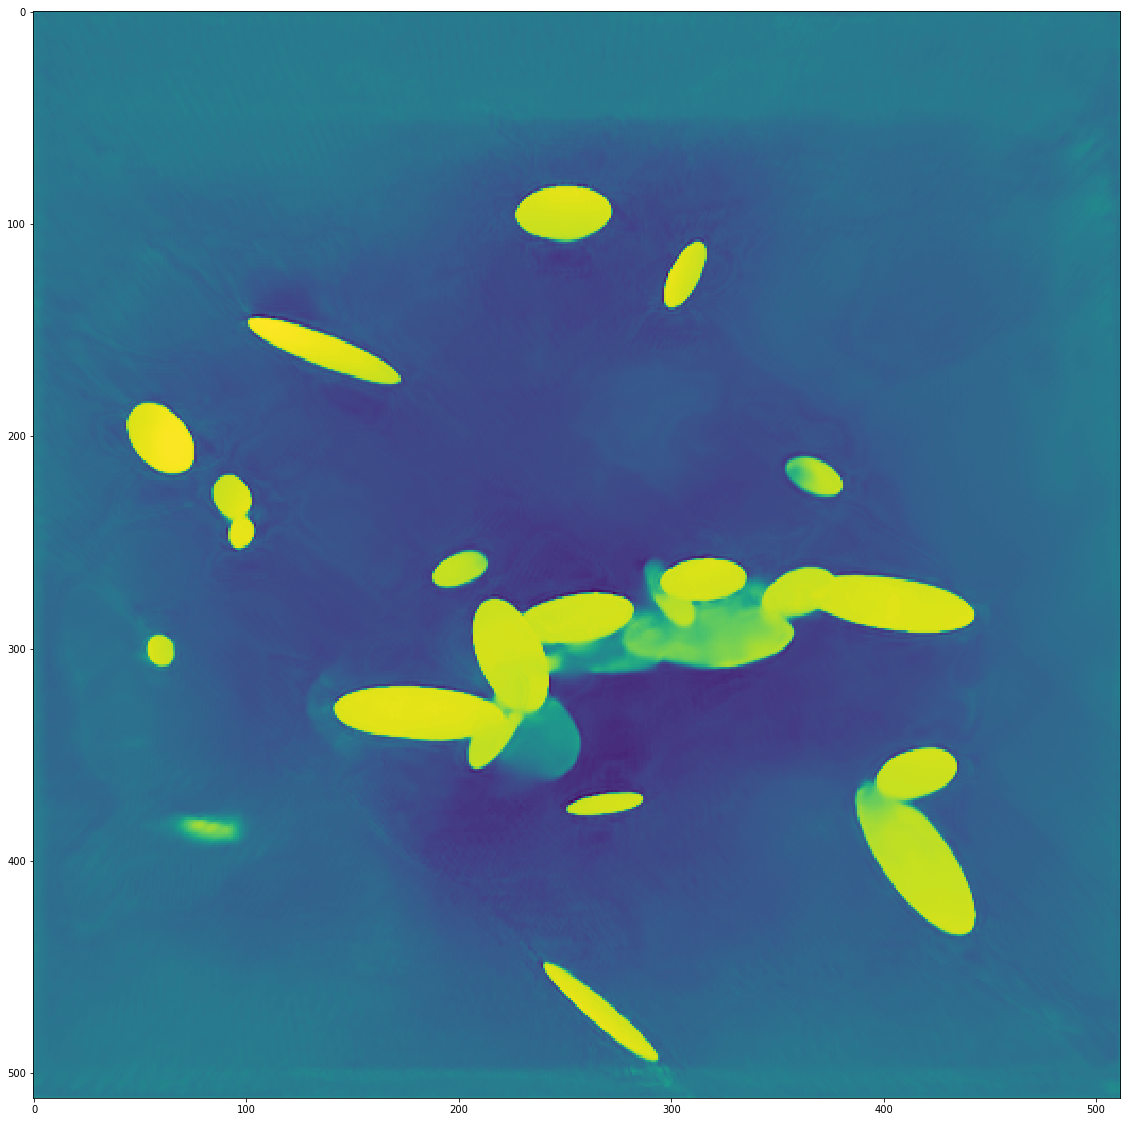

1.0 0.0


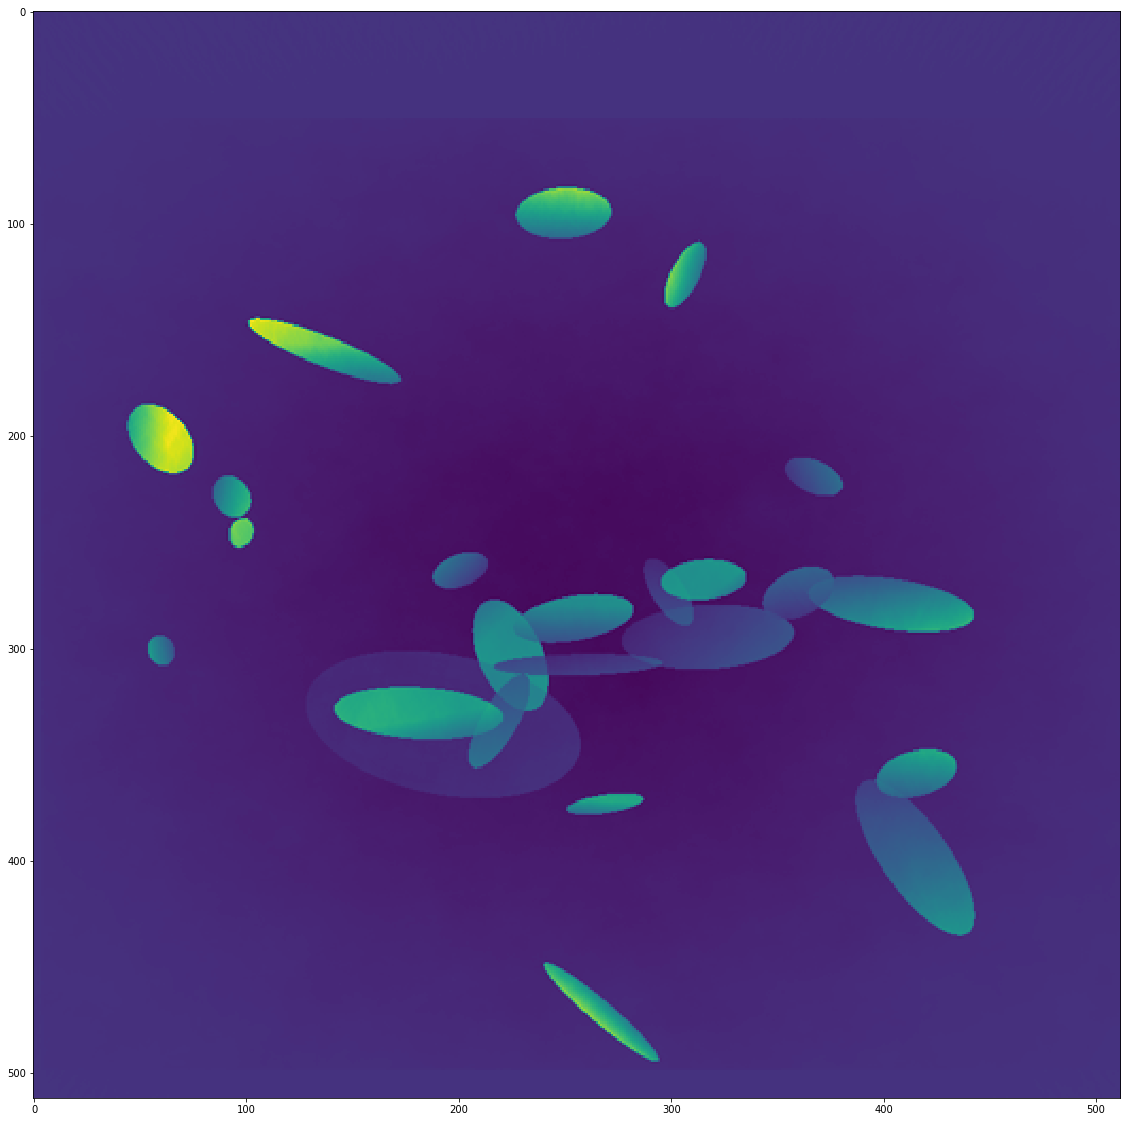

1.0 0.0


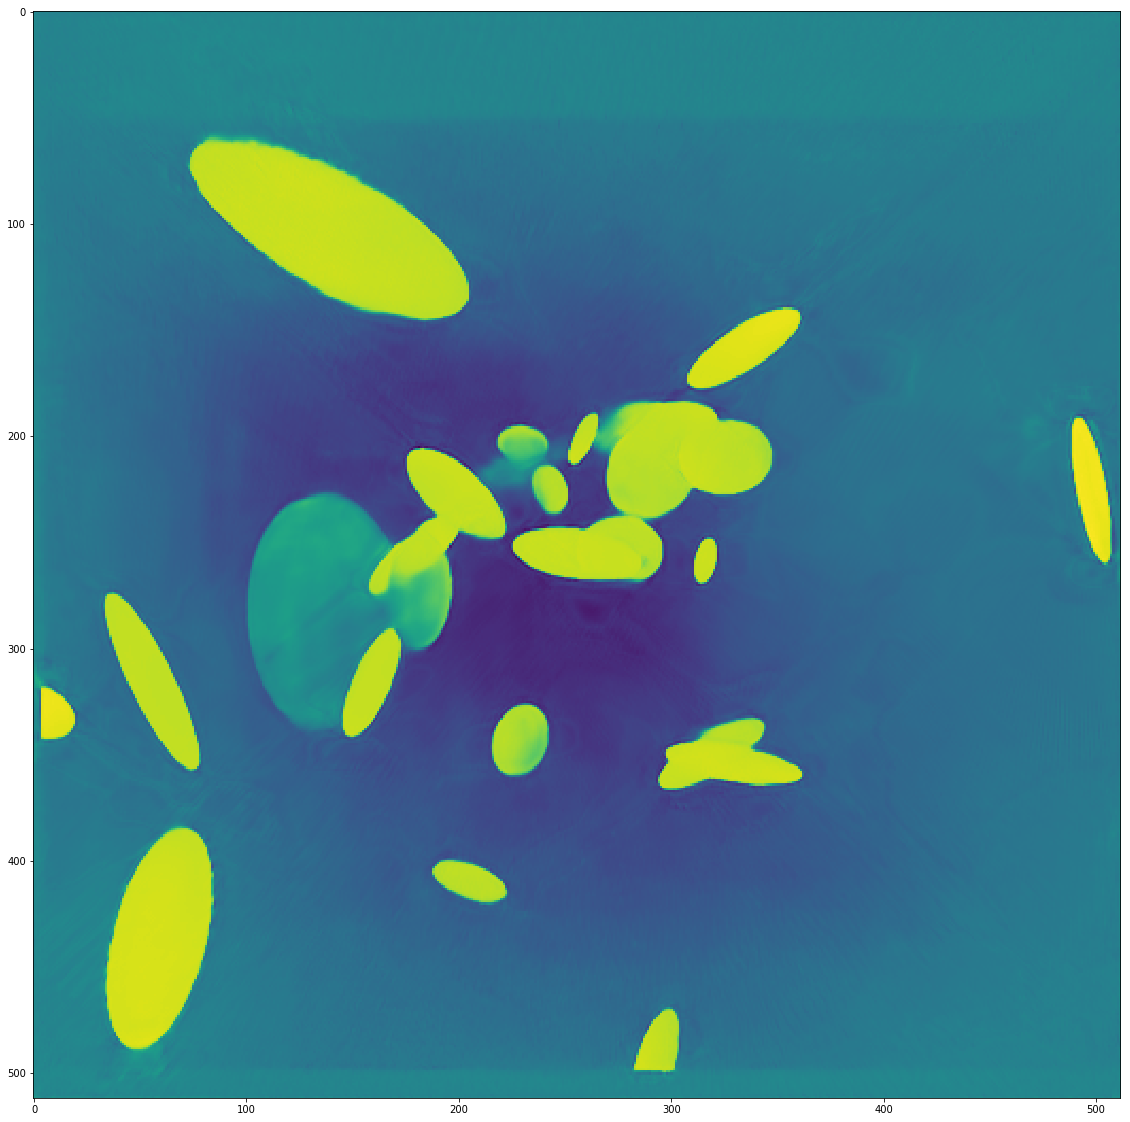

1.0 0.0


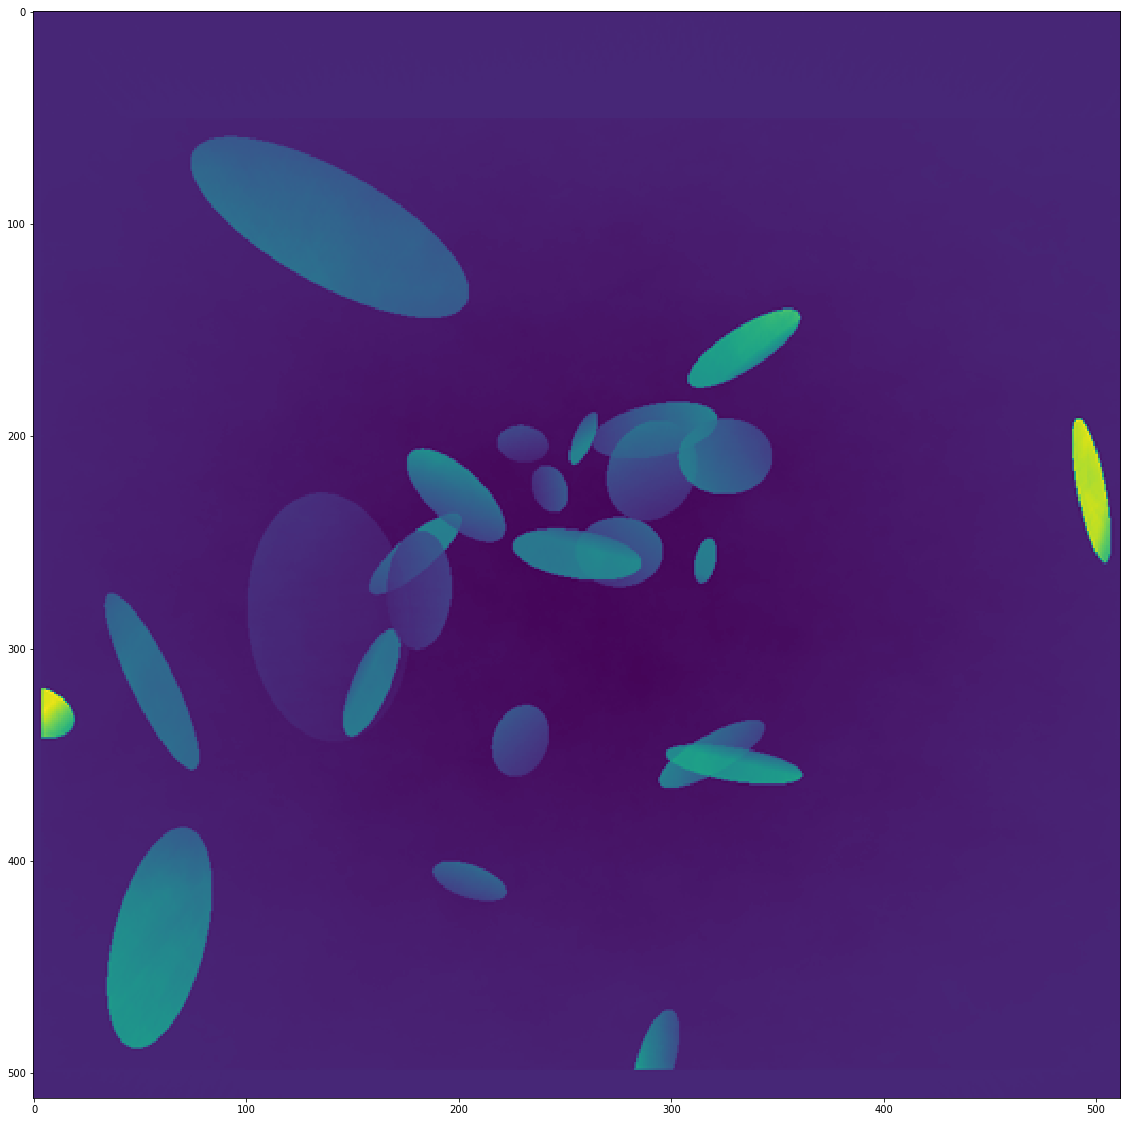

In [27]:
for out,ref in zip(mean_out_train,refs_train):
    
    max_out, min_out = (np.amax(out), np.amin(out))
    print(np.amax((out-min_out)/(max_out-min_out)), np.amin((out-min_out)/(max_out-min_out)))
    plt.figure(figsize=(20,20))
    plt.imshow(np.squeeze((out-min_out)/(max_out-min_out)))
    plt.show()
    
    max_ref, min_ref = (np.amax(ref), np.amin(ref))
    print(np.amax((ref-min_ref)/(max_ref-min_ref)), np.amin((ref-min_ref)/(max_ref-min_ref)))
    plt.figure(figsize=(20,20))
    plt.imshow(np.squeeze((ref-min_ref)/(max_ref-min_ref)))
    plt.show()

In [24]:
print(np.amax(refs_train[0]), np.amin(refs_train[0]))

12.867002216553406 -1.8297920344342813


In [26]:
amin, amax = (np.amax(refs_train[0]), np.amin(refs_train[0]))

print(np.amax((refs_train[0]-amin)/(amax-amin)), np.amin((refs_train[0]-amin)/(amax-amin)))

1.0 -0.0


In [29]:
a = np.random.random_sample(10000)
b = np.random.random_sample(10000)
c = np.random.random_sample(10000)

In [31]:
a = np.ones(10000)
b = np.ones(10000)
c = np.ones(10000)

In [32]:
print(np.mean(a), np.var(a))
print(np.mean(b), np.var(b))
print(np.mean(c), np.var(c))

1.0 0.0
1.0 0.0
1.0 0.0
